<a href="https://colab.research.google.com/github/dongsikchoi/ML_Time-Series_EDA/blob/master/BG_Prediction_Univariate_Filter_X_01_25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 필요 라이브러리 로드

In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

matplotlib.rcParams['axes.labelsize']=14
matplotlib.rcParams['xtick.labelsize']=12
matplotlib.rcParams['ytick.labelsize']=12
matplotlib.rcParams['text.color']='k'

In [2]:
# Colab
#from google.colab import auth
#auth.authenticate_user()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
pd.set_option('display.max_columns',500) 
#출력시 생략 X

### 데이터셋 설정 

In [5]:
#df=pd.read_excel("BG_Dataset/BG_Sample55.xlsx")

In [6]:
# Colab
df = pd.read_excel("/content/drive/MyDrive/BG_Dataset/BG_Sample41.xlsx")
#df = pd.read_csv("/content/drive/MyDrive/BG_Dataset/BG_Sample46.csv")


In [7]:
df.shape

(1947, 14)

In [8]:
df.head(13)

색인 타임스탬프(YYYY-MM-DDThh:mm:ss) 이벤트 유형 이벤트 하위 유형                환자 정보  \
0    1                        NaN     이름       NaN                  sch   
1    2                        NaN      성       NaN                    s   
2    3                        NaN   생년월일       NaN  1990-01-01 00:00:00   
3    4                        NaN     장치       NaN                  NaN   
4    5                        NaN     경고        하락                  NaN   
5    6                        NaN     경고        높음                  NaN   
6    7                        NaN     경고        낮음                  NaN   
7    8                        NaN     경고     신호 손실                  NaN   
8    9                        NaN     경고        상승                  NaN   
9   10                        NaN     경고   긴급하게 낮음                  NaN   
10  11        2020-10-23T11:17:46     교정       NaN                  NaN   
11  12        2020-10-23T11:21:27     교정       NaN                  NaN   
12  13        2020-10-23T11:21:30    EGV       NaN                  NaN   

                   장치 정보 소스 장치 ID  포도당 값 (mg/dL)  인슐린 값(u)  탄수화물 값 (그램)  \
0                    NaN      NaN            NaN       NaN          NaN   
1                    NaN      NaN            NaN       NaN          NaN   
2                    NaN      NaN            NaN       NaN          NaN   
3   Dexcom G5 Mobile App  Android            NaN       NaN          NaN   
4                    NaN  Android            NaN       NaN          NaN   
5                    NaN  Android          400.0       NaN          NaN   
6                    NaN  Android           75.0       NaN          NaN   
7                    NaN  Android            NaN       NaN          NaN   
8                    NaN  Android            NaN       NaN          NaN   
9                    NaN  Android           55.0       NaN          NaN   
10                   NaN  Android          182.0       NaN          NaN   
11                   NaN  Android          195.0       NaN          NaN   
12                   NaN  Android          184.0       NaN          NaN   

   기간(hh:mm:ss)  포도당 변화율 (mg/dL/min)  트랜스미터 시간 (배장 정수) 트랜스미터 ID  
0           NaN                  NaN               NaN      NaN  
1           NaN                  NaN               NaN      NaN  
2           NaN                  NaN               NaN      NaN  
3           NaN                  NaN               NaN      NaN  
4           NaN                  3.0               NaN      NaN  
5           NaN                  NaN               NaN      NaN  
6           NaN                  NaN               NaN      NaN  
7      00:30:00                  NaN               NaN      NaN  
8           NaN                  3.0               NaN      NaN  
9           NaN                  NaN               NaN      NaN  
10          NaN                  NaN               NaN   42J400  
11          NaN                  NaN               NaN   42J400  
12          NaN                  NaN            7808.0   42J400

In [9]:
#필요없는 열 제거
cols = ['색인', '이벤트 하위 유형', '환자 정보', '장치 정보', '소스 장치 ID', '기간(hh:mm:ss)', '포도당 변화율 (mg/dL/min)', '트랜스미터 시간 (배장 정수)', '트랜스미터 ID']
df.drop(cols, axis=1, inplace=True)


In [10]:
df=df.rename({'타임스탬프(YYYY-MM-DDThh:mm:ss)':'Timestamp','포도당 값 (mg/dL)':'Glucose','이벤트 유형':'Event',
             '인슐린 값(u)':'Insulin','탄수화물 값 (그램)':'Meal'},axis='columns')

In [11]:
df['Event'].value_counts()

EGV     1923
교정        12
경고         6
탄수화물       2
이름         1
성          1
장치         1
생년월일       1
Name: Event, dtype: int64

In [12]:
df['Glucose'].value_counts()

165.0    34
169.0    34
161.0    31
171.0    31
166.0    31
         ..
267.0     1
264.0     1
117.0     1
128.0     1
400.0     1
Name: Glucose, Length: 169, dtype: int64

In [13]:
df.tail()

Timestamp Event  Glucose  Insulin  Meal
1942  2020-10-30T08:21:09   EGV    192.0      NaN   NaN
1943  2020-10-30T08:26:09   EGV    193.0      NaN   NaN
1944  2020-10-30T08:31:09   EGV    195.0      NaN   NaN
1945  2020-10-30T08:36:09   EGV    195.0      NaN   NaN
1946  2020-10-30T08:41:08   EGV    191.0      NaN   NaN

In [14]:
# 인슐린 투여횟수
df['Insulin'].value_counts()

Series([], Name: Insulin, dtype: int64)

In [15]:
# 식사 횟수
df['Meal'].value_counts()

0.0    2
Name: Meal, dtype: int64

In [16]:
df.head(15)

Timestamp Event  Glucose  Insulin  Meal
0                   NaN    이름      NaN      NaN   NaN
1                   NaN     성      NaN      NaN   NaN
2                   NaN  생년월일      NaN      NaN   NaN
3                   NaN    장치      NaN      NaN   NaN
4                   NaN    경고      NaN      NaN   NaN
5                   NaN    경고    400.0      NaN   NaN
6                   NaN    경고     75.0      NaN   NaN
7                   NaN    경고      NaN      NaN   NaN
8                   NaN    경고      NaN      NaN   NaN
9                   NaN    경고     55.0      NaN   NaN
10  2020-10-23T11:17:46    교정    182.0      NaN   NaN
11  2020-10-23T11:21:27    교정    195.0      NaN   NaN
12  2020-10-23T11:21:30   EGV    184.0      NaN   NaN
13  2020-10-23T11:26:24   EGV    183.0      NaN   NaN
14  2020-10-23T11:31:23   EGV    193.0      NaN   NaN

In [17]:
# Timestamp != NaN일 때까지 count하고 
# Nan에 해당하는 인스턴스 제거 
df=df.dropna(subset=['Timestamp'])

In [18]:
df.head(20)

Timestamp Event  Glucose  Insulin  Meal
10  2020-10-23T11:17:46    교정    182.0      NaN   NaN
11  2020-10-23T11:21:27    교정    195.0      NaN   NaN
12  2020-10-23T11:21:30   EGV    184.0      NaN   NaN
13  2020-10-23T11:26:24   EGV    183.0      NaN   NaN
14  2020-10-23T11:31:23   EGV    193.0      NaN   NaN
15  2020-10-23T11:36:24   EGV    192.0      NaN   NaN
16  2020-10-23T11:41:24   EGV    187.0      NaN   NaN
17  2020-10-23T11:46:24   EGV    185.0      NaN   NaN
18  2020-10-23T11:51:24   EGV    184.0      NaN   NaN
19  2020-10-23T11:56:22   EGV    183.0      NaN   NaN
20  2020-10-23T12:01:23   EGV    183.0      NaN   NaN
21  2020-10-23T12:06:22   EGV    184.0      NaN   NaN
22  2020-10-23T12:11:24   EGV    187.0      NaN   NaN
23  2020-10-23T12:16:22   EGV    189.0      NaN   NaN
24  2020-10-23T12:17:27  탄수화물      NaN      NaN   0.0
25  2020-10-23T12:21:23   EGV    194.0      NaN   NaN
26  2020-10-23T12:26:24   EGV    202.0      NaN   NaN
27  2020-10-23T12:31:23   EGV    218.0      NaN   NaN
28  2020-10-23T12:36:23   EGV    232.0      NaN   NaN
29  2020-10-23T12:41:25   EGV    250.0      NaN   NaN

In [19]:
df.shape

(1937, 5)

In [20]:
# drop한 인스턴스가 있어서 인덱스 리셋
df=df.sort_values(by=['Timestamp'],axis=0,ascending=True)
df=df.reset_index(drop=True)

In [21]:
df.head(15)

Timestamp Event  Glucose  Insulin  Meal
0   2020-10-23T11:17:46    교정    182.0      NaN   NaN
1   2020-10-23T11:21:27    교정    195.0      NaN   NaN
2   2020-10-23T11:21:30   EGV    184.0      NaN   NaN
3   2020-10-23T11:26:24   EGV    183.0      NaN   NaN
4   2020-10-23T11:31:23   EGV    193.0      NaN   NaN
5   2020-10-23T11:36:24   EGV    192.0      NaN   NaN
6   2020-10-23T11:41:24   EGV    187.0      NaN   NaN
7   2020-10-23T11:46:24   EGV    185.0      NaN   NaN
8   2020-10-23T11:51:24   EGV    184.0      NaN   NaN
9   2020-10-23T11:56:22   EGV    183.0      NaN   NaN
10  2020-10-23T12:01:23   EGV    183.0      NaN   NaN
11  2020-10-23T12:06:22   EGV    184.0      NaN   NaN
12  2020-10-23T12:11:24   EGV    187.0      NaN   NaN
13  2020-10-23T12:16:22   EGV    189.0      NaN   NaN
14  2020-10-23T12:17:27  탄수화물      NaN      NaN   0.0

In [22]:
df.shape

(1937, 5)

In [23]:
# 높음, 낮음, 교정 인덱스 저장 
high_list=[]
low_list=[]
calib_list=[]
insulin_list=[]
meal_list=[]

In [24]:
def isNaN(num):
    return num==num

In [25]:
# 혈당 '높음' 빈도 카운트
def glucose_count_high(df,col):
    count=0
    for i, row in df.iterrows():
         val = row[col]
         if val=='높음':
            count=count+1
            high_list.append(i)
    print('높음 : ',count)
    

In [26]:
# 혈당 '낮음' 빈도 카운트
def glucose_count_low(df,col):
    count=0
    for i, row in df.iterrows():
         val = row[col]
         if val=='낮음':
            count=count+1
            low_list.append(i)
    print('낮음 : ',count)

In [27]:
# 혈당 '교정' 빈도 카운트
def calibration_count_low(df,col):
    count=0
    for i, row in df.iterrows():
         val = row[col]
         if val=='교정':
            count=count+1
            calib_list.append(i)
    print('교정 : ',count)

In [28]:
# 인슐린 카운트 
#def insul_count(df,col):
#    count=0
#    for i, row in df.iterrows():
#         val = row[col]
#         if val==0:
#            count=count+1
#            insulin_list.append(i)
#    print('인슐린 : ',count)

In [29]:
# 인슐린 카운트 
def insul_count(df,col):
    count=0
    for i, row in df.iterrows():
         val = row[col]
         if isNaN(val)==True:
            count=count+1
            insulin_list.append(i)
    print('인슐린 : ',count)

In [30]:
# 식사 횟수 카운트 
#def meal_count(df,col):
#    count=0
#    for i, row in df.iterrows():
#         val = row[col]
#         if val==0:
#            count=count+1
#            meal_list.append(i)
#    print('식사 횟수 : ',count)

In [31]:
# 식사 횟수 카운트 
def meal_count(df,col):
    count=0
    for i, row in df.iterrows():
         val = row[col]
         if isNaN(val)==True:
            count=count+1
            meal_list.append(i)
    print('식사 횟수 : ',count)

In [32]:
glucose_count_high(df,'Glucose')

높음 :  0


In [33]:
print('높음 개수 :',len(high_list))

높음 개수 : 0


In [34]:
print('낮음 개수 :',len(low_list))

낮음 개수 : 0


In [35]:
print('교정 개수 :',len(calib_list))

교정 개수 : 0


In [36]:
glucose_count_low(df,'Glucose')

낮음 :  0


In [37]:
low_list

[]

In [38]:
calibration_count_low(df,'Event')

교정 :  12


In [39]:
calib_list

[0, 1, 116, 259, 401, 514, 752, 891, 1363, 1495, 1611, 1655]

In [40]:
insul_count(df,'Insulin')

인슐린 :  0


In [41]:
insulin_list

[]

In [42]:
meal_count(df,'Meal')

식사 횟수 :  2


In [43]:
meal_list

[14, 76]

In [44]:
df['Insulin'].value_counts()

Series([], Name: Insulin, dtype: int64)

In [45]:
df['Meal'].value_counts()

0.0    2
Name: Meal, dtype: int64

In [46]:
isNaN(df['Glucose'][14])

False

In [47]:
import math
for i in insulin_list:
    
    if isNaN(df['Glucose'][i+1]):
        df['Insulin'][i+1]=0
        continue
    if isNaN(df['Glucose'][i+2]):
        df['Insulin'][i+2]=0
        continue
    if isNaN(df['Glucose'][i+3]):
        df['Insulin'][i+3]=0
        continue
    if isNaN(df['Glucose'][i+4]):
        df['Insulin'][i+4]=0
        continue

In [48]:
for i in meal_list:
    
    if isNaN(df['Glucose'][i+1]):
        df['Meal'][i+1]=0
        continue
    if isNaN(df['Glucose'][i+2]):
        df['Meal'][i+2]=0
        continue
    if isNaN(df['Glucose'][i+3]):
        df['Meal'][i+3]=0
        continue
    if isNaN(df['Glucose'][i+4]):
        df['Meal'][i+4]=0
        continue

In [49]:
import math
math.isnan(df['Glucose'][14])

True

In [50]:
insulin_list

[]

In [51]:
SetList1 = set(insulin_list)
SetList2 = set(meal_list)

C = list((SetList2.difference(SetList1)))

insulin_list.extend(C)

In [52]:
insulin_list

[76, 14]

In [53]:
df=df.drop(insulin_list)

In [54]:
df[10:20]

Timestamp Event  Glucose  Insulin  Meal
10  2020-10-23T12:01:23   EGV    183.0      NaN   NaN
11  2020-10-23T12:06:22   EGV    184.0      NaN   NaN
12  2020-10-23T12:11:24   EGV    187.0      NaN   NaN
13  2020-10-23T12:16:22   EGV    189.0      NaN   NaN
15  2020-10-23T12:21:23   EGV    194.0      NaN   0.0
16  2020-10-23T12:26:24   EGV    202.0      NaN   NaN
17  2020-10-23T12:31:23   EGV    218.0      NaN   NaN
18  2020-10-23T12:36:23   EGV    232.0      NaN   NaN
19  2020-10-23T12:41:25   EGV    250.0      NaN   NaN
20  2020-10-23T12:46:23   EGV    243.0      NaN   NaN

In [55]:
df['Glucose'].unique()

array([182., 195., 184., 183., 193., 192., 187., 185., 189., 194., 202.,
       218., 232., 250., 243., 271., 298., 318., 324., 306., 312., 325.,
       315., 346., 326., 322., 272., 268., 255., 239., 229., 228., 242.,
       225., 217., 222., 227., 223., 213., 207., 201., 199., 191., 197.,
       210., 230., 236., 234., 205., 208., 212., 204., 214., 226., 235.,
       244., 259., 247., 254., 258., 240., 237., 238., 231., 216., 206.,
       200., 211., 163., 174., 170., 168., 156., 153., 151., 149., 147.,
       146., 145., 144., 155., 157., 162., 164., 166., 175., 177., 172.,
       169., 158., 179., 167., 161., 143., 150., 152., 159., 154., 181.,
       188., 198., 196., 180., 173., 171., 165., 137., 135., 134., 133.,
       160., 190., 186., 176., 178., 141., 148., 139., 136., 130., 122.,
       125., 118., 110., 108., 107., 112., 115., 119., 120., 116., 124.,
       127., 132., 140., 142., 138., 123., 121., 128., 129., 117., 113.,
       114., 209., 215., 221., 241., 257., 245., 24

In [56]:
df.isnull().sum()

Timestamp       0
Event           0
Glucose         0
Insulin      1935
Meal         1933
dtype: int64

In [57]:
df['Event'].value_counts()

EGV    1923
교정       12
Name: Event, dtype: int64

### 높음 낮음 고정 (추후 전처리 과정에서 400,408,416,408,400 이런 식으로 선형으로 변환해줄 것)

In [58]:
def fix_glucose_low(df,col):
    for i, row in df.iterrows():
        val = row[col]
        if val=='낮음':
            df.loc[i,col] = 60

In [59]:
def fix_glucose(df,col):
    for i, row in df.iterrows():
        val = row[col]
        if val=='높음':
            df.loc[i,col] = 400
        elif val > 400:
            df.loc[i,col]=400

In [60]:
fix_glucose_low(df,'Glucose')

In [61]:
fix_glucose(df,'Glucose')

In [62]:
df['Glucose'].value_counts()

169.0    34
165.0    34
171.0    31
166.0    31
161.0    31
         ..
112.0     1
267.0     1
132.0     1
128.0     1
271.0     1
Name: Glucose, Length: 166, dtype: int64

In [63]:
df.isnull().sum()

Timestamp       0
Event           0
Glucose         0
Insulin      1935
Meal         1933
dtype: int64

In [64]:
df['Event'].unique()

array(['교정', 'EGV'], dtype=object)

In [65]:
## 이벤트에 '운동' 있어서 혈당값 비어있음 
# 모델 안돌아감 
df=df.dropna(subset=['Glucose'])

In [66]:
# drop한 인스턴스가 있어서 인덱스 리셋
df=df.sort_values(by=['Timestamp'],axis=0,ascending=True)
df=df.reset_index(drop=True)

In [67]:
new_insul_list =[]
new_meal_list =[]
new_insul_and_meal_list=[]

for i in range(len(df)):
    if (df['Insulin'][i] ==0 and df['Meal'][i]==0):
        new_insul_and_meal_list.append(i)
    if (df['Insulin'][i]==0 and df['Meal'][i]!=0):
        new_insul_list.append(i)
    if (df['Insulin'][i]!=0 and df['Meal'][i]==0):
        new_meal_list.append(i)

In [68]:
new_meal_list

[14, 75]

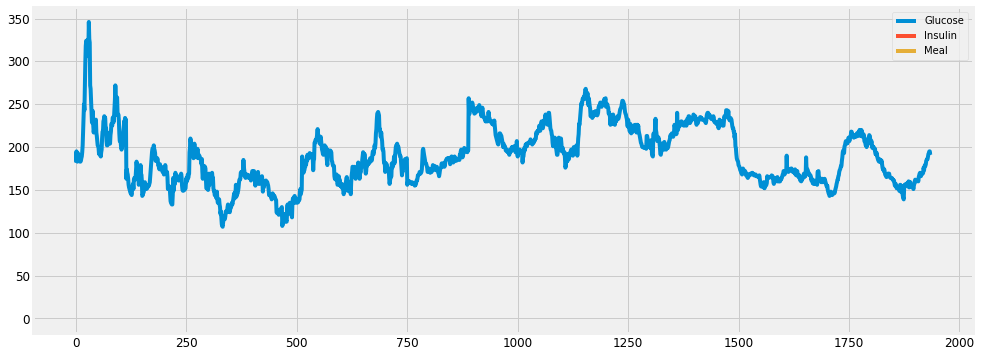

In [69]:
df.plot(figsize=(15,6))
plt.show()

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


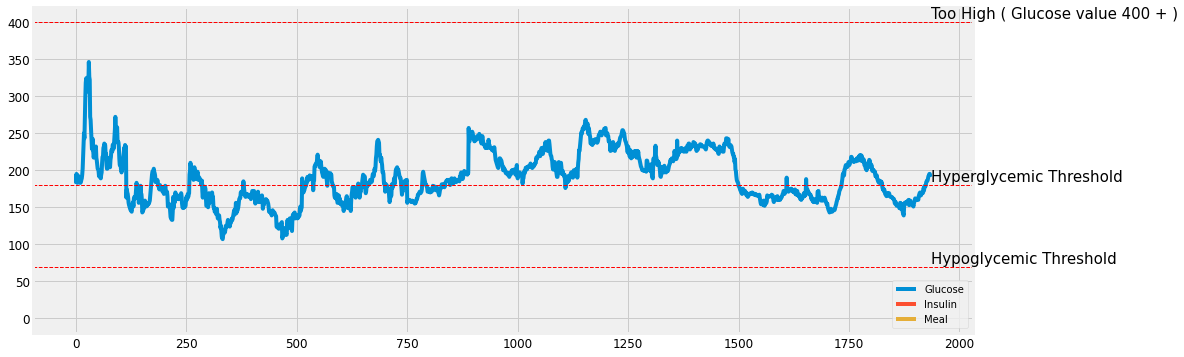

In [70]:
df.plot(figsize=(15,6))
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
#plt.annotate(df['Timestamp'][13],xy=(-50,40),xytext=(-50,0),fontsize=20,bbox=dict(boxstyle='square',
#                                                               color='white'),arrowprops=dict(facecolor='black'))
#plt.annotate(df['Timestamp'][len(df['Timestamp'])],xytext=(-,0),fontsize=20,bbox=dict(boxstyle='square',
 #                                                              color='white'))
plt.text(len(df['Timestamp']),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(df['Timestamp']),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(df['Timestamp']),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

#y=70
#plt.plot(y,'b--',linestyles='--'),
#plt.hlines(70,linestyles='--')
plt.show()

In [71]:
#df.drop(0,inplace=True)

In [72]:
# drop한 인스턴스가 있어서 인덱스 리셋
#df=df.sort_values(by=['Timestamp'],axis=0,ascending=True)
#df=df.reset_index(drop=True)
#df.head(21)

In [73]:
# 인슐린, 탄수화물 투여시 혈당값 NULL
# 그래서 t시점에 t-2 , t-1 크기비교해서 upper면 이렇게 lower면 이렇게 해서 interpolation ( 보간)
# 이거 위에 참고사항 drop하고 나서 적용 해줘야됨
#insul=list()
#import math
#def interpolate_glucose(df,col):
#    #insul=list()
    
#    for i, row in df.iterrows():
#        val=row[col]
#        if math.isnan(val):
#            if df['Glucose'][i-2] >= df['Glucose'][i-1]:
#                c = (df['Glucose'][i-2] - df['Glucose'][i-1]) / 2 
#                df.loc[i,col]= df['Glucose'][i-1] - c
#                insul.append(i)
#                print(insul)
                
#            if df['Glucose'][i-2] < df['Glucose'][i-1]:
#                c = (df['Glucose'][i-2] - df['Glucose'][i-1]) / 2 
#                df.loc[i,col]= df['Glucose'][i-1] - c
#                insul.append(i)
#                print(insul)
        
           

In [74]:
# 인슐린 탄수화물 인덱스 문제 해결 파트 
#insul=list()
#meal=list()
#import math
#def interpolate_glucose(df,col):
    #insul=list()
    
#    for i, row in df.iterrows():
#        val=row[col]
        #df=df.sort_values(by=['Timestamp'],axis=0,ascending=True)
        #df=df.reset_index(drop=True)
#        if math.isnan(val):
 #           if df['Event'][i]=='인슐린':
  #              if df['Glucose'][i-1] is None:
   #                 insul.append(i-2)
                    
                    
    #            else:
     #               insul.append(i-1)
                    
      #      if df['Event'][i]=='탄수화물':
       #         if df['Glucose'][i-1] is None:
        #            meal.append(i-2)
                    
         #       else:
          #          meal.append(i-1)
                    

In [75]:
#interpolate_glucose(df,'Glucose')

In [76]:
#meal

In [77]:
#insul

In [78]:
df['Glucose'].isnull().sum()

0

In [79]:
insul_glucose_value=list()
for i in new_insul_list:
    insul_glucose_value.append(df['Glucose'][i])

In [80]:
meal_glucose_value=list()
for i in new_meal_list:
    meal_glucose_value.append(df['Glucose'][i])

In [81]:
insul_and_meal_glucose_value = list()
for i in new_insul_and_meal_list:
    insul_and_meal_glucose_value.append(df['Glucose'][i])

In [82]:
#len = len(df['Timestamp'])
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


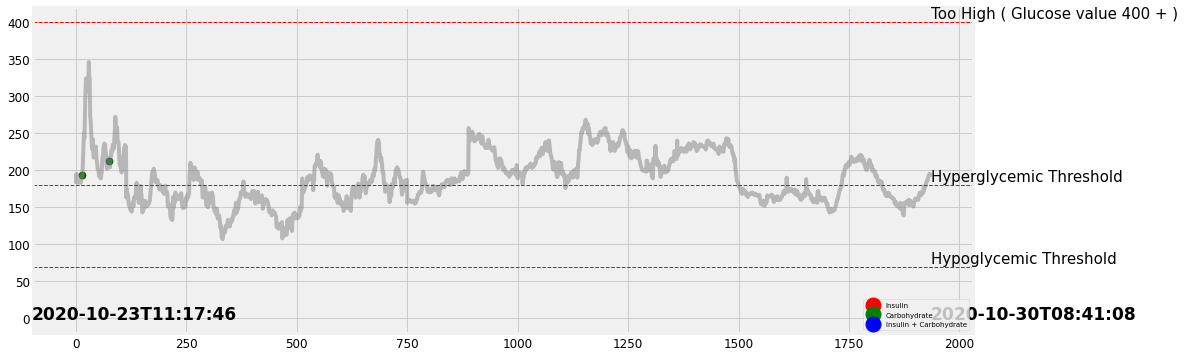

In [83]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

df.plot(figsize=(15,6),color='gray',alpha=0.5)
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
#plt.axhline(y=60,c='black',linestyle='--',linewidth=1)
plt.text(len(df['Timestamp']),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(df['Timestamp']),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)

plt.scatter(new_insul_list,insul_glucose_value,edgecolor='black',s=50,label='Insulin',marker='o',c='red')
plt.scatter(new_meal_list,meal_glucose_value,edgecolor='black',s=50,label='Carbohydrate',marker='o',c='green')
plt.scatter(new_insul_and_meal_list,insul_and_meal_glucose_value,edgecolor='black',s=50,label='Insulin + Carbohydrate',marker='o',c='blue')

red_patch = mpatches.Patch(color='red',label='Insulin')

red_line = mlines.Line2D([],[],color='red',marker='o',markersize=15,label='Insulin')
green_line = mlines.Line2D([],[],color='green',marker='o',markersize=15,label='Carbohydrate')
blue_line = mlines.Line2D([],[],color='blue',marker='o',markersize=15,label='Insulin + Carbohydrate')
plt.text(len(df['Timestamp']),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.text(len(df['Timestamp']),60,'',family='Times New Roman',size=15)
#plt.text(len(df['Timestamp']),-1,df['Timestamp'][len(df['Timestamp'])],family='Times New Roman',
#         fontweight='bold',size=20)
plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp']),-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.legend(['Insulin','Carbohydrate','Insulin + Carbohydrate'],loc='best',fontsize='x-small',handles=[red_line,green_line,blue_line])
#plt.text(-100,-1,df['Timestamp'][14],family='Times New Roman',

#         fontweight='bold',size=20)

#y=70
#plt.plot(y,'b--',linestyles='--'),
#plt.hlines(70,linestyles='--')
plt.show()

In [84]:
for i in range(len(df)):
    if isNaN(df['Insulin'][i]):
        df['Insulin'][i]=1
    else:
        df['Insulin'][i]=0
        
     

In [85]:
for i in range(len(df)):
    if isNaN(df['Meal'][i]):
        df['Meal'][i]=1
    else:
        df['Meal'][i]=0
        

In [86]:
df[1900:1950]

Timestamp Event  Glucose  Insulin  Meal
1900  2020-10-30T05:51:08   EGV    162.0      0.0   0.0
1901  2020-10-30T05:56:09   EGV    161.0      0.0   0.0
1902  2020-10-30T06:01:07   EGV    161.0      0.0   0.0
1903  2020-10-30T06:06:08   EGV    160.0      0.0   0.0
1904  2020-10-30T06:11:08   EGV    161.0      0.0   0.0
1905  2020-10-30T06:16:08   EGV    161.0      0.0   0.0
1906  2020-10-30T06:21:08   EGV    162.0      0.0   0.0
1907  2020-10-30T06:26:08   EGV    160.0      0.0   0.0
1908  2020-10-30T06:31:08   EGV    165.0      0.0   0.0
1909  2020-10-30T06:36:09   EGV    167.0      0.0   0.0
1910  2020-10-30T06:41:07   EGV    169.0      0.0   0.0
1911  2020-10-30T06:46:08   EGV    170.0      0.0   0.0
1912  2020-10-30T06:51:09   EGV    169.0      0.0   0.0
1913  2020-10-30T06:56:08   EGV    166.0      0.0   0.0
1914  2020-10-30T07:01:08   EGV    168.0      0.0   0.0
1915  2020-10-30T07:06:08   EGV    169.0      0.0   0.0
1916  2020-10-30T07:11:08   EGV    170.0      0.0   0.0
1917  2020-10-30T07:16:09   EGV    169.0      0.0   0.0
1918  2020-10-30T07:21:08   EGV    170.0      0.0   0.0
1919  2020-10-30T07:26:08   EGV    176.0      0.0   0.0
1920  2020-10-30T07:31:09   EGV    173.0      0.0   0.0
1921  2020-10-30T07:36:09   EGV    177.0      0.0   0.0
1922  2020-10-30T07:41:08   EGV    179.0      0.0   0.0
1923  2020-10-30T07:46:08   EGV    178.0      0.0   0.0
1924  2020-10-30T07:51:08   EGV    180.0      0.0   0.0
1925  2020-10-30T07:56:08   EGV    184.0      0.0   0.0
1926  2020-10-30T08:01:08   EGV    185.0      0.0   0.0
1927  2020-10-30T08:06:08   EGV    186.0      0.0   0.0
1928  2020-10-30T08:11:09   EGV    186.0      0.0   0.0
1929  2020-10-30T08:16:09   EGV    189.0      0.0   0.0
1930  2020-10-30T08:21:09   EGV    192.0      0.0   0.0
1931  2020-10-30T08:26:09   EGV    193.0      0.0   0.0
1932  2020-10-30T08:31:09   EGV    195.0      0.0   0.0
1933  2020-10-30T08:36:09   EGV    195.0      0.0   0.0
1934  2020-10-30T08:41:08   EGV    191.0      0.0   0.0

In [87]:
def fix_glucose_value(df,col):
    for i, row in df.iterrows():
        val = row[col]
        
        df.loc[i,col] = math.floor(val)

In [88]:
fix_glucose_value(df,'Glucose')

## 이제 여기부터 DL 모델 돌려볼 것 
+ 일단 모델부터 간단하게 돌려보고 성능 측정
+ 그리고 전처리 해가면서 성능 비교

In [89]:
import numpy as np
import tensorflow as tf
import random as rn

In [90]:
# 재현 가능한 결과를 만들기 위해 시드값 설정 
import os 
import random
seed_num = 42
os.environ['PYTHONHASHSEED']=str(seed_num)

random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

In [91]:
from tensorflow.compat.v1.keras import backend as K

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [92]:
#from keras import backend as K
#session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
#sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
#tf.compat.v1.keras.backend.set_session(sess)


In [93]:
from sklearn.metrics import mean_squared_error
def RMSE(y_test,y_predict):
    return np.sqrt(mean_squared_error(y_test,y_predict))

In [94]:
leaky_relu = tf.nn.leaky_relu

In [95]:
def clarke_error_grid(ref_values, pred_values, title_string):

    #Checking to see if the lengths of the reference and prediction arrays are the same
    assert (len(ref_values) == len(pred_values)), "Unequal number of values (reference : {}) (prediction : {}).".format(len(ref_values), len(pred_values))

    #Checks to see if the values are within the normal physiological range, otherwise it gives a warning
    if max(ref_values) > 400 or max(pred_values) > 400:
        print ("Input Warning: the maximum reference value {} or the maximum prediction value {} exceeds the normal physiological range of glucose (<400 mg/dl).".format(max(ref_values), max(pred_values)))
    if min(ref_values) < 0 or min(pred_values) < 0:
        print ("Input Warning: the minimum reference value {} or the minimum prediction value {} is less than 0 mg/dl.".format(min(ref_values),  min(pred_values)))

    #Clear plot
    plt.clf()

    #Set up plot
    plt.scatter(ref_values, pred_values, marker='o', color='black', s=8)
    plt.title(title_string + " Clarke Error Grid")
    plt.xlabel("Reference Concentration (mg/dl)")
    plt.ylabel("Prediction Concentration (mg/dl)")
    plt.xticks([0, 50, 100, 150, 200, 250, 300, 350, 400])
    plt.yticks([0, 50, 100, 150, 200, 250, 300, 350, 400])
    plt.gca().set_facecolor('white')

    #Set axes lengths
    plt.gca().set_xlim([0, 400])
    plt.gca().set_ylim([0, 400])
    plt.gca().set_aspect((400)/(400))

    #Plot zone lines
    plt.plot([0,400], [0,400], ':', c='black')                      #Theoretical 45 regression line
    plt.plot([0, 175/3], [70, 70], '-', c='black')
    #plt.plot([175/3, 320], [70, 400], '-', c='black')
    plt.plot([175/3, 400/1.2], [70, 400], '-', c='black')           #Replace 320 with 400/1.2 because 100*(400 - 400/1.2)/(400/1.2) =  20% error
    plt.plot([70, 70], [84, 400],'-', c='black')
    plt.plot([0, 70], [180, 180], '-', c='black')
    plt.plot([70, 290],[180, 400],'-', c='black')
    # plt.plot([70, 70], [0, 175/3], '-', c='black')
    plt.plot([70, 70], [0, 56], '-', c='black')                     #Replace 175.3 with 56 because 100*abs(56-70)/70) = 20% error
    # plt.plot([70, 400],[175/3, 320],'-', c='black')
    plt.plot([70, 400], [56, 320],'-', c='black')
    plt.plot([180, 180], [0, 70], '-', c='black')
    plt.plot([180, 400], [70, 70], '-', c='black')
    plt.plot([240, 240], [70, 180],'-', c='black')
    plt.plot([240, 400], [180, 180], '-', c='black')
    plt.plot([130, 180], [0, 70], '-', c='black')

    #Add zone titles
    plt.text(30, 15, "A", fontsize=15)
    plt.text(370, 260, "B", fontsize=15)
    plt.text(280, 370, "B", fontsize=15)
    plt.text(160, 370, "C", fontsize=15)
    plt.text(160, 15, "C", fontsize=15)
    plt.text(30, 140, "D", fontsize=15)
    plt.text(370, 120, "D", fontsize=15)
    plt.text(30, 370, "E", fontsize=15)
    plt.text(370, 15, "E", fontsize=15)

    #Statistics from the data
    zone = [0] * 5
    for i in range(len(ref_values)):
        if (ref_values[i] <= 70 and pred_values[i] <= 70) or (pred_values[i] <= 1.2*ref_values[i] and pred_values[i] >= 0.8*ref_values[i]):
            zone[0] += 1    #Zone A

        elif (ref_values[i] >= 180 and pred_values[i] <= 70) or (ref_values[i] <= 70 and pred_values[i] >= 180):
            zone[4] += 1    #Zone E

        elif ((ref_values[i] >= 70 and ref_values[i] <= 290) and pred_values[i] >= ref_values[i] + 110) or ((ref_values[i] >= 130 and ref_values[i] <= 180) and (pred_values[i] <= (7/5)*ref_values[i] - 182)):
            zone[2] += 1    #Zone C
        elif (ref_values[i] >= 240 and (pred_values[i] >= 70 and pred_values[i] <= 180)) or (ref_values[i] <= 175/3 and pred_values[i] <= 180 and pred_values[i] >= 70) or ((ref_values[i] >= 175/3 and ref_values[i] <= 70) and pred_values[i] >= (6/5)*ref_values[i]):
            zone[3] += 1    #Zone D
        else:
            zone[1] += 1    #Zone B

    return plt, zone

## 15분

In [96]:
def uni_data(dataset,start_index,end_index, history_size, target_size):
    data=[]
    labels=[]
    
    start_index= start_index+history_size
    if end_index is None:
    #if end_index > len(dataset)-1:
        end_index = len(dataset)-target_size
        
    for i in range(start_index,end_index):
        indices = range(i-history_size,i)
        
        data.append(np.reshape(dataset[indices],(history_size,1)))
        #data.append(np.reshape(dataset[indices],(history_size)))
        labels.append(dataset[i+target_size])
    return np.array(data),np.array(labels)

In [97]:
raw_seq = df['Glucose']
raw_seq=raw_seq.to_numpy(dtype='int64')

In [98]:
len(raw_seq) * 0.7

1354.5

In [99]:
# SG필터 테스트 
#import scipy.signal 

#yhat = scipy.signal.savgol_filter(raw_seq,15,5)
#plt.plot(raw_seq)
#plt.plot(yhat,color='red')
#plt.show()

In [100]:
# SG필터 적용하는 부분 
# x_train_uni_origin 이런 식이었음 
#TRAIN_SPLIT=int(len(raw_seq)*0.7)
#uni_past_history=6
#uni_future_target=2 # 이거 -1이면 naive method 
#x_train_uni,y_train_uni = uni_data(,0,TRAIN_SPLIT,
#                                  uni_past_history,
#                                  uni_future_target)
#x_val_uni,y_val_uni=uni_data(yhat,TRAIN_SPLIT,None,
#                            uni_past_history,
#                            uni_future_target)

In [101]:
TRAIN_SPLIT=int(len(raw_seq)*0.7)
uni_past_history=6
uni_future_target=2 # 이거 -1이면 naive method 
x_train_uni_origin,y_train_uni_origin = uni_data(raw_seq,0,TRAIN_SPLIT,
                                  uni_past_history,
                                  uni_future_target)
x_val_uni_origin,y_val_uni_origin=uni_data(raw_seq,TRAIN_SPLIT,None,
                            uni_past_history,
                            uni_future_target)

In [102]:
TRAIN_SPLIT=int(len(raw_seq)*0.7)
uni_past_history=6
uni_future_target=2 # 이거 -1이면 naive method 
x_train_uni,y_train_uni = uni_data(raw_seq,0,TRAIN_SPLIT,
                                  uni_past_history,
                                  uni_future_target)
x_val_uni,y_val_uni=uni_data(raw_seq,TRAIN_SPLIT,None,
                            uni_past_history,
                            uni_future_target)

In [103]:
y_val_uni.shape

(573,)

In [104]:
y_train_uni.shape

(1348,)

In [105]:
#y_train_uni_origin[:10]

In [106]:
#y_train_uni.shape
df[:15]

Timestamp Event  Glucose  Insulin  Meal
0   2020-10-23T11:17:46    교정    182.0      0.0   0.0
1   2020-10-23T11:21:27    교정    195.0      0.0   0.0
2   2020-10-23T11:21:30   EGV    184.0      0.0   0.0
3   2020-10-23T11:26:24   EGV    183.0      0.0   0.0
4   2020-10-23T11:31:23   EGV    193.0      0.0   0.0
5   2020-10-23T11:36:24   EGV    192.0      0.0   0.0
6   2020-10-23T11:41:24   EGV    187.0      0.0   0.0
7   2020-10-23T11:46:24   EGV    185.0      0.0   0.0
8   2020-10-23T11:51:24   EGV    184.0      0.0   0.0
9   2020-10-23T11:56:22   EGV    183.0      0.0   0.0
10  2020-10-23T12:01:23   EGV    183.0      0.0   0.0
11  2020-10-23T12:06:22   EGV    184.0      0.0   0.0
12  2020-10-23T12:11:24   EGV    187.0      0.0   0.0
13  2020-10-23T12:16:22   EGV    189.0      0.0   0.0
14  2020-10-23T12:21:23   EGV    194.0      0.0   1.0

In [107]:
x_train_uni[5:10]

array([[[192],
        [187],
        [185],
        [184],
        [183],
        [183]],

       [[187],
        [185],
        [184],
        [183],
        [183],
        [184]],

       [[185],
        [184],
        [183],
        [183],
        [184],
        [187]],

       [[184],
        [183],
        [183],
        [184],
        [187],
        [189]],

       [[183],
        [183],
        [184],
        [187],
        [189],
        [194]]])

In [108]:
y_train_uni[5:10]

array([189, 194, 202, 218, 232])

In [109]:
#df['Glucose'].head(10)

In [110]:
x_train_uni.shape[-2:]

(6, 1)

### RNN - 15분

In [111]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

In [112]:
from keras.layers import SimpleRNN

In [113]:
#n_steps = 3
#delay=3
#n_features=1

In [114]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [115]:
model = Sequential()
model.add(SimpleRNN(50,activation='relu',input_shape=x_train_uni.shape[-2:],return_sequences=False)) #recurrent_dropout=0.2
model.add(Dense(1))

In [116]:
model.compile(optimizer='adam',loss='mse')
model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)
K.clear_session()
val_rnn_15_predict_result = model.predict(x_val_uni,verbose=0)

In [117]:
# 예측값 상한선 = 400 
for i in range(len(val_rnn_15_predict_result)):
    if val_rnn_15_predict_result[i] >= 400: 
        val_rnn_15_predict_result[i]=400
# Val set RMSE 
print(' Vanila RNN (Simple RNN) - RMSE (15min) : ',RMSE(y_val_uni_origin,val_rnn_15_predict_result))
val_rnn_15 = RMSE(y_val_uni_origin,val_rnn_15_predict_result)


 Vanila RNN (Simple RNN) - RMSE (15min) :  4.913885289448855


#### Validation

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


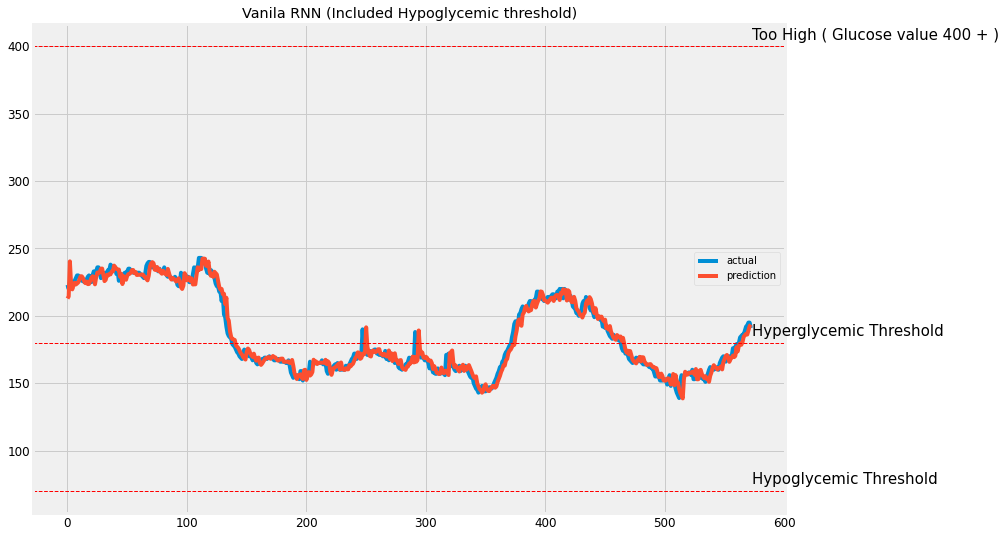

In [118]:
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(val_rnn_15_predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(val_rnn_15_predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(val_rnn_15_predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(val_rnn_15_predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Vanila RNN (Included Hypoglycemic threshold)',family='Times New Roman')
plt.legend()
plt.show()

In [119]:
val_rnn_15_predict_result

array([[212.85153],
       [214.38956],
       [240.43323],
       [223.58986],
       [219.64207],
       [222.60121],
       [224.56505],
       [223.27557],
       [223.98055],
       [224.81366],
       [227.1989 ],
       [229.42006],
       [229.29881],
       [227.94925],
       [225.44534],
       [224.25354],
       [225.46906],
       [223.5398 ],
       [223.64296],
       [225.80455],
       [228.19229],
       [229.4035 ],
       [228.10048],
       [223.38437],
       [228.6342 ],
       [232.17574],
       [231.53145],
       [232.21774],
       [235.02   ],
       [235.08174],
       [230.6354 ],
       [225.78748],
       [226.75166],
       [230.53294],
       [229.99478],
       [231.09366],
       [230.77188],
       [232.9386 ],
       [232.94492],
       [237.2755 ],
       [236.06898],
       [234.84663],
       [234.4316 ],
       [234.3897 ],
       [229.05556],
       [231.1719 ],
       [223.60353],
       [229.38104],
       [227.37556],
       [226.77211],


In [120]:
len(val_rnn_15_predict_result)

573

In [121]:
y_val_uni_origin

array([223, 220, 225, 226, 224, 225, 226, 228, 230, 230, 229, 227, 226,
       227, 225, 225, 227, 229, 230, 229, 225, 230, 233, 232, 233, 236,
       236, 232, 228, 229, 232, 231, 232, 232, 234, 234, 238, 237, 236,
       236, 236, 231, 233, 226, 231, 229, 228, 231, 232, 232, 233, 235,
       235, 233, 234, 232, 232, 232, 232, 232, 232, 231, 230, 229, 228,
       231, 237, 239, 240, 240, 236, 236, 238, 235, 236, 234, 233, 235,
       233, 233, 232, 236, 233, 230, 229, 230, 229, 228, 227, 228, 229,
       227, 223, 222, 224, 232, 230, 227, 229, 230, 227, 229, 225, 225,
       225, 231, 236, 234, 236, 236, 243, 243, 243, 239, 239, 242, 235,
       232, 233, 231, 234, 233, 232, 228, 224, 222, 222, 218, 218, 211,
       215, 201, 199, 192, 187, 185, 184, 183, 179, 178, 177, 175, 173,
       172, 170, 169, 168, 173, 175, 174, 172, 171, 170, 172, 169, 167,
       169, 169, 165, 164, 165, 166, 167, 168, 168, 169, 169, 168, 169,
       170, 169, 169, 168, 167, 167, 168, 168, 168, 166, 166, 16

In [122]:
## test 


In [123]:
from pandas import DataFrame
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import probplot

#residuals=DataFrame(residuals)

Text(0.5, 1.0, 'Simple RNN Normal Q-Q Plot')

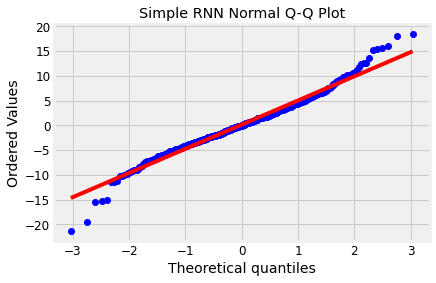

In [124]:
residuals = [y_val_uni_origin[i]-val_rnn_15_predict_result[i] for i in range(len(val_rnn_15_predict_result))]
residuals = y_val_uni_origin - val_rnn_15_predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Simple RNN Normal Q-Q Plot")

#### 잔차

Text(0.5, 1.0, 'Simple RNN Normal Q-Q Plot')

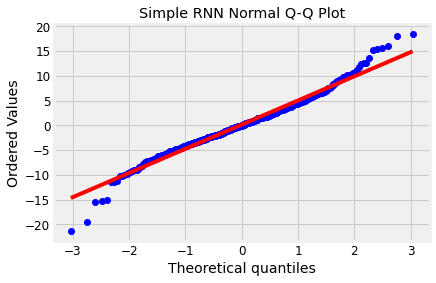

In [125]:
probplot(residuals,dist="norm",plot=plt)
plt.title("Simple RNN Normal Q-Q Plot")

In [126]:
residuals=DataFrame(residuals)

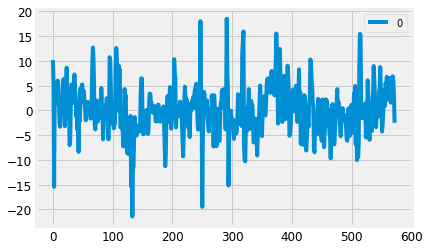

In [127]:
residuals.plot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fabc033cb10>]],
      dtype=object)

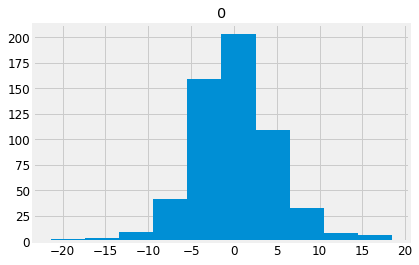

In [128]:

residuals.hist()

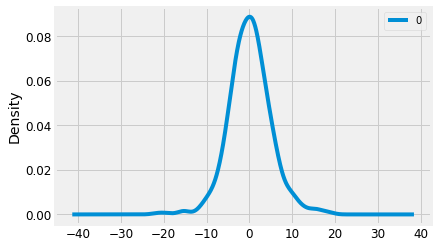

In [129]:
residuals.plot(kind='kde')

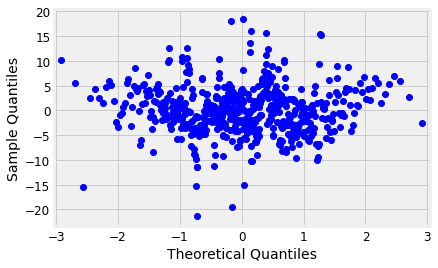

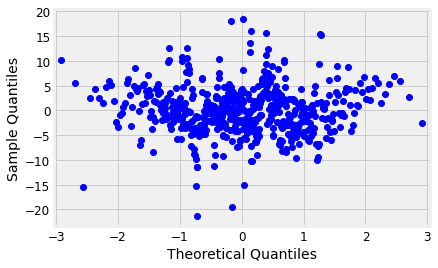

In [130]:
from statsmodels.graphics.gofplots import qqplot
residuals=np.array(residuals)
qqplot(residuals)

In [131]:
# 트레이닝셋 rmse 구하는 부분 
train_rnn_15_predict_result = model.predict(x_train_uni,verbose=0)
for i in range(len(train_rnn_15_predict_result)):
    if train_rnn_15_predict_result[i] >= 400: 
        train_rnn_15_predict_result[i]=400            
print(' Training set / Vanila RNN (Simple RNN) - RMSE (15min) : ',RMSE(y_train_uni_origin,train_rnn_15_predict_result))
train_rnn_15=RMSE(y_train_uni_origin,train_rnn_15_predict_result)

 Training set / Vanila RNN (Simple RNN) - RMSE (15min) :  10.65663330197851


#### Train

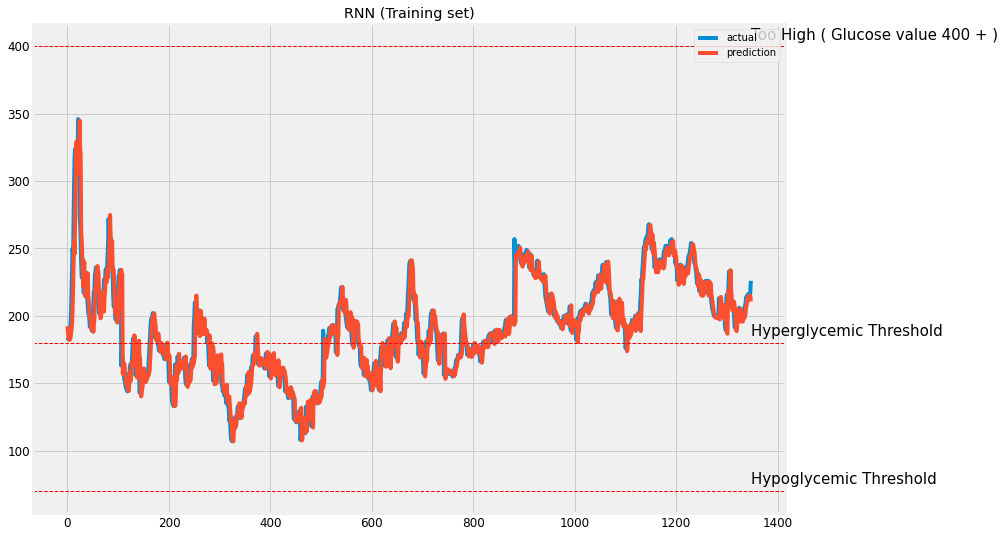

In [132]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni,label='actual')
plt.plot(train_rnn_15_predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(train_rnn_15_predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(train_rnn_15_predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(train_rnn_15_predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('RNN (Training set)',family='Times New Roman')
plt.legend()
plt.show()

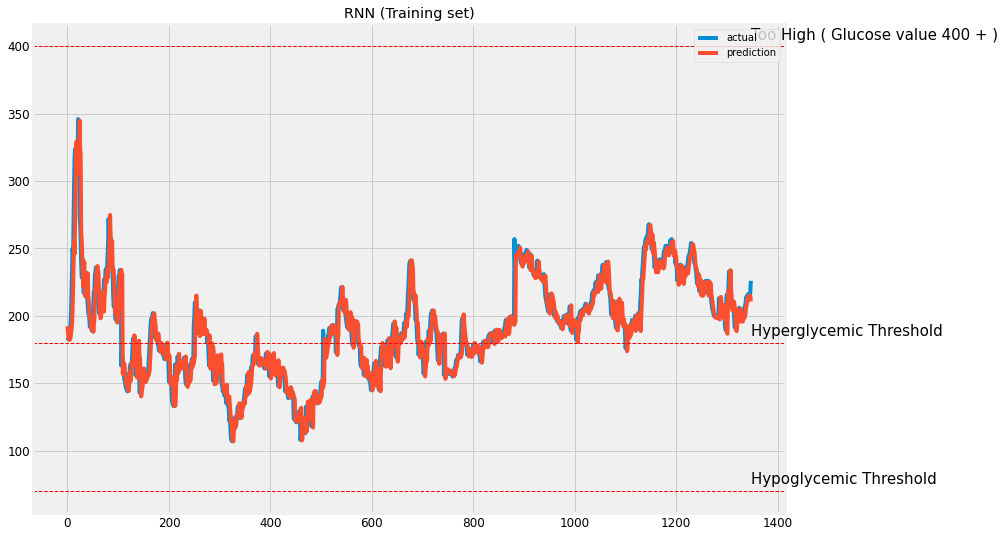

In [133]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni,label='actual')
plt.plot(train_rnn_15_predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(train_rnn_15_predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(train_rnn_15_predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(train_rnn_15_predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('RNN (Training set)',family='Times New Roman')
plt.legend()
plt.show()

### LSTM - 15분

In [134]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [135]:
model = Sequential()
model.add(LSTM(50,activation='relu',input_shape=x_train_uni.shape[-2:])) #recurrent_dropout=0.2, unit_forget_bias=False
model.add(Dense(1))


In [136]:
model.compile(optimizer='adam',loss='mse')
model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)
K.clear_session()
val_lstm_15_predict_result = model.predict(x_val_uni,verbose=0)

In [137]:
# 예측값 상한선 = 400 
for i in range(len(val_lstm_15_predict_result)):
    if val_lstm_15_predict_result[i] >= 400: 
        val_lstm_15_predict_result[i]=400
print(' LSTM - RMSE (15min) : ',RMSE(y_val_uni_origin,val_lstm_15_predict_result))
val_lstm_15=RMSE(y_val_uni_origin,val_lstm_15_predict_result)

 LSTM - RMSE (15min) :  5.101476407447841


In [138]:
val_lstm_15_predict_result

array([[215.32385],
       [214.90892],
       [228.68738],
       [224.71208],
       [220.135  ],
       [222.5276 ],
       [224.53119],
       [223.15984],
       [223.37852],
       [224.39125],
       [225.75975],
       [227.58119],
       [228.36528],
       [227.91254],
       [226.53421],
       [225.2821 ],
       [225.4153 ],
       [224.51213],
       [223.80373],
       [224.94446],
       [226.70251],
       [227.93942],
       [227.84259],
       [225.36124],
       [226.87215],
       [230.1345 ],
       [230.49696],
       [230.92244],
       [233.16843],
       [234.14503],
       [231.92368],
       [228.44621],
       [227.62508],
       [229.40526],
       [229.6639 ],
       [229.97435],
       [230.46   ],
       [231.60742],
       [232.26903],
       [234.59727],
       [235.43964],
       [234.63995],
       [234.40977],
       [234.41273],
       [231.48428],
       [230.9313 ],
       [227.55592],
       [227.8845 ],
       [228.31114],
       [226.9855 ],


In [139]:
TRAIN_SPLIT

1354

#### 잔차

Text(0.5, 1.0, 'LSTM Normal Q-Q Plot')

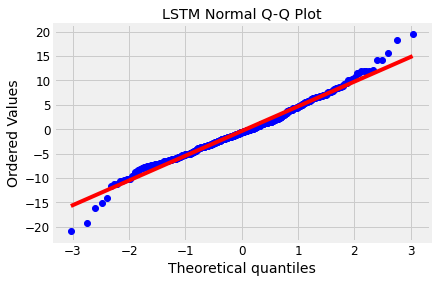

In [140]:
residuals = [y_val_uni_origin[i]-val_lstm_15_predict_result[i] for i in range(len(val_lstm_15_predict_result))]
residuals = y_val_uni_origin - val_lstm_15_predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("LSTM Normal Q-Q Plot")

#### Validation

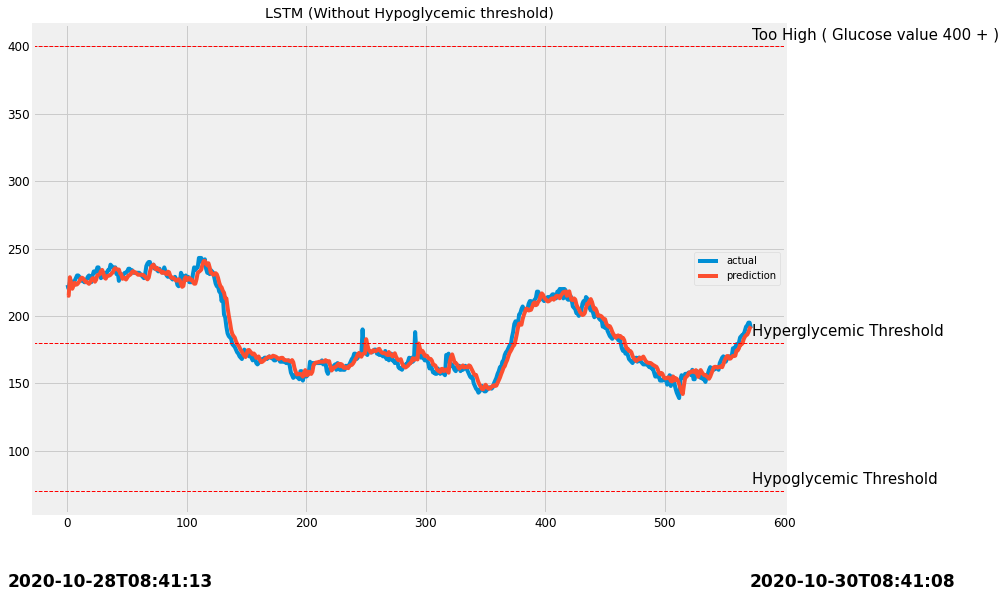

In [141]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(val_lstm_15_predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(val_lstm_15_predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(val_lstm_15_predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(val_lstm_15_predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('LSTM (Without Hypoglycemic threshold)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [142]:
# 트레이닝셋 RMSE 계산 
train_lstm_15_predict_result = model.predict(x_train_uni,verbose=0)

# 예측값 상한선 = 400 
for i in range(len(train_lstm_15_predict_result)):
    if train_lstm_15_predict_result[i] >= 400: 
        train_lstm_15_predict_result[i]=400
print(' LSTM - RMSE (15min) Training set : ',RMSE(y_train_uni_origin,train_lstm_15_predict_result))
train_lstm_15 =RMSE(y_train_uni_origin,train_lstm_15_predict_result)

 LSTM - RMSE (15min) Training set :  11.22637793148515


#### Train

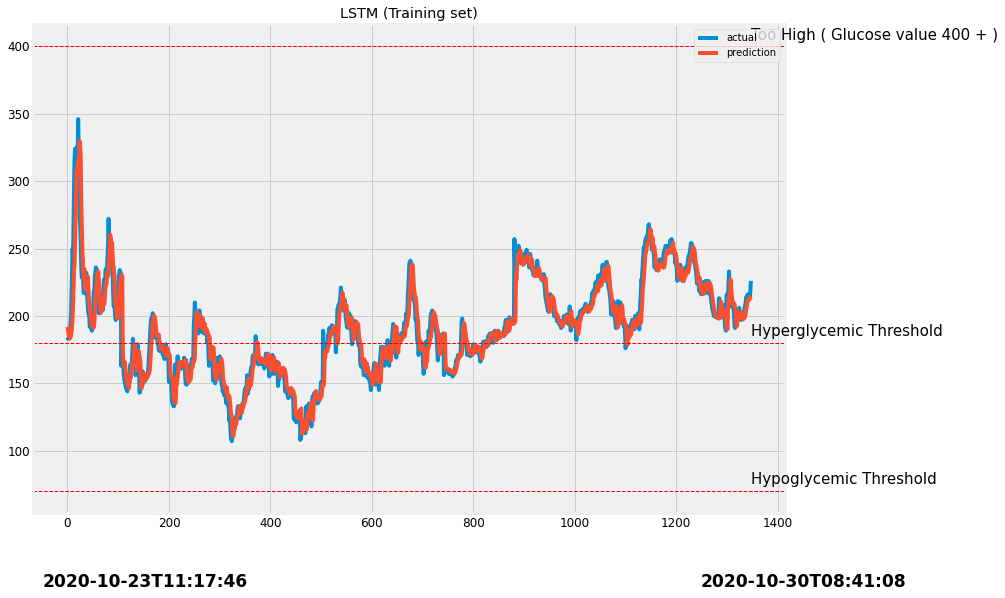

In [143]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni,label='actual')
plt.plot(train_lstm_15_predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(train_lstm_15_predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(train_lstm_15_predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(train_lstm_15_predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('LSTM (Training set)',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(train_lstm_15_predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend()
plt.show()

### Stacked LSTM - 15분

In [144]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [145]:
model = Sequential()
model.add(LSTM(50,activation='relu',return_sequences=True,input_shape=x_train_uni.shape[-2:]))
model.add(LSTM(50,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [146]:
model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)

In [147]:
K.clear_session()

In [148]:
val_slstm_15_predict_result = model.predict(x_val_uni,verbose=0)


In [149]:
for i in range(len(val_slstm_15_predict_result)):
    if val_slstm_15_predict_result[i] >= 400: 
        val_slstm_15_predict_result[i]=400

In [150]:
val_slstm_15_predict_result

array([[216.65517],
       [215.995  ],
       [230.808  ],
       [227.75797],
       [219.84116],
       [224.04472],
       [227.51761],
       [223.87695],
       [225.21524],
       [227.06367],
       [228.41005],
       [230.33618],
       [230.72835],
       [229.86557],
       [228.1513 ],
       [226.77792],
       [227.10971],
       [226.09402],
       [225.23521],
       [227.12556],
       [229.51578],
       [230.44482],
       [229.83624],
       [226.4998 ],
       [228.48482],
       [233.57658],
       [232.47797],
       [233.04128],
       [236.51097],
       [236.78673],
       [233.06886],
       [229.08965],
       [228.40155],
       [231.46062],
       [231.62904],
       [231.88231],
       [232.81293],
       [234.2725 ],
       [234.6462 ],
       [237.62543],
       [237.82729],
       [236.59254],
       [236.32661],
       [236.63428],
       [232.35695],
       [231.4896 ],
       [228.17516],
       [227.81401],
       [230.16234],
       [228.4546 ],


In [151]:
print(' Stacked LSTM - RMSE(15min) : ',RMSE(y_val_uni_origin,val_slstm_15_predict_result))
val_stacklstm_15 =RMSE(y_val_uni_origin,val_slstm_15_predict_result)

 Stacked LSTM - RMSE(15min) :  5.420636371588639


#### Validation

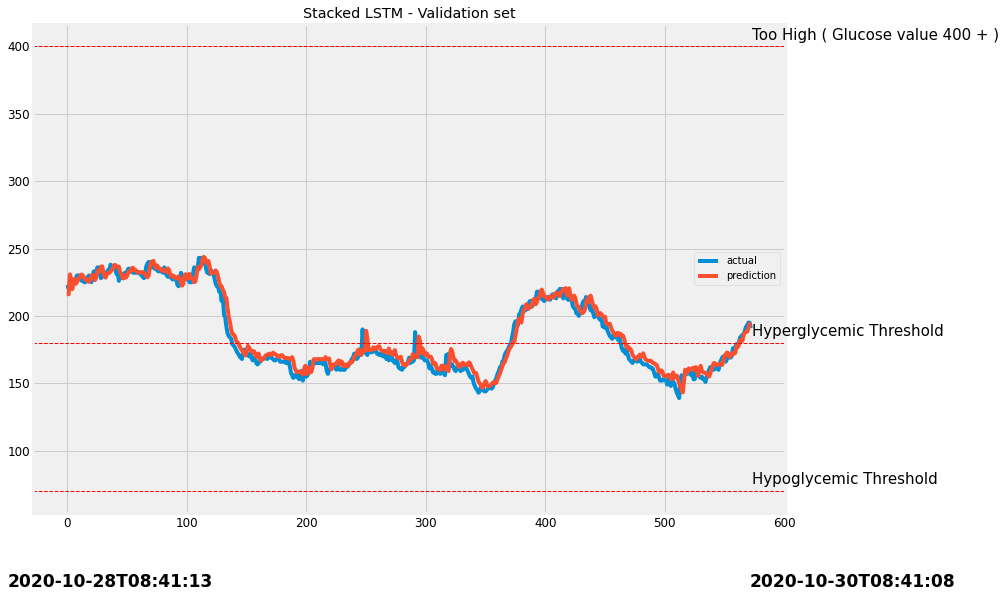

In [152]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(val_slstm_15_predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(val_slstm_15_predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(val_slstm_15_predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(val_slstm_15_predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(val_slstm_15_predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Validation set',family='Times New Roman')
plt.legend(loc='best')

plt.show()

#### 잔차

Text(0.5, 1.0, 'Stacked LSTM Normal Q-Q Plot')

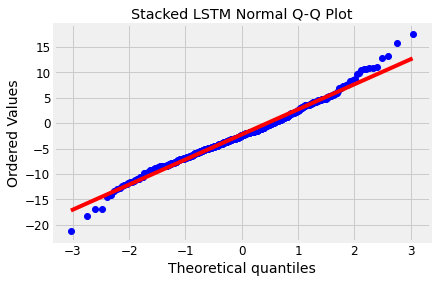

In [153]:
residuals = [y_val_uni[i]-val_slstm_15_predict_result[i] for i in range(len(val_slstm_15_predict_result))]
residuals = y_val_uni - val_slstm_15_predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Stacked LSTM Normal Q-Q Plot")

In [154]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / STACKED LSTM - RMSE (15min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_stacklstm_15 = RMSE(y_train_uni_origin,predict_result)

 Training set / STACKED LSTM - RMSE (15min) Training set :  10.903569837765918


#### Train

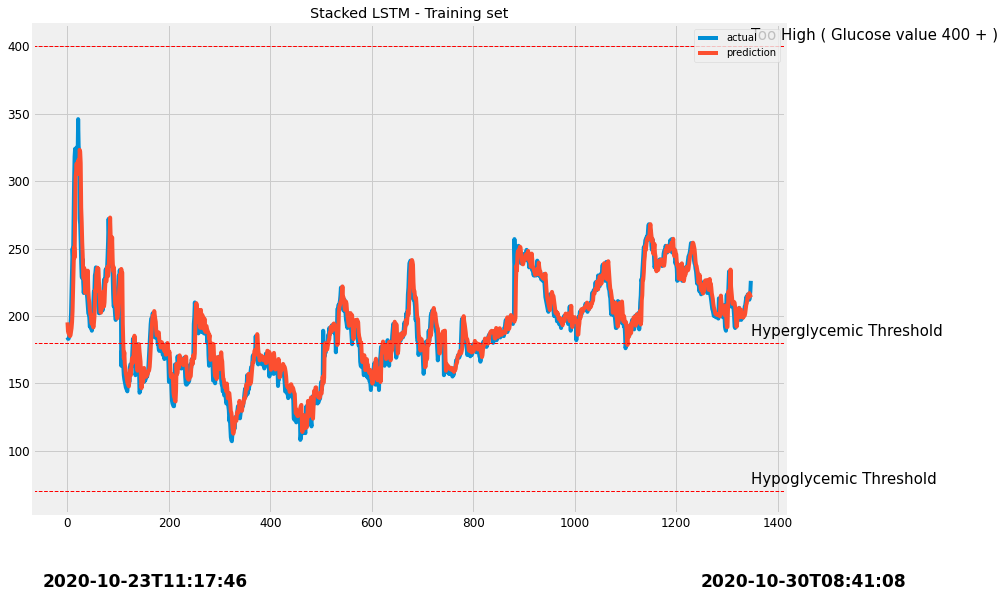

In [155]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### Bidirectional LSTM - 15분

In [156]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [157]:
from keras.layers import Bidirectional

model = Sequential()
model.add(Bidirectional(LSTM(50,activation='relu'),input_shape=x_train_uni.shape[-2:]))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [158]:
model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)

In [159]:
K.clear_session()

In [160]:
val_bilstm_15_predict_result = model.predict(x_val_uni,verbose=0)

In [161]:
for i in range(len(val_bilstm_15_predict_result)):
    if val_bilstm_15_predict_result[i] >= 400: 
        val_bilstm_15_predict_result[i]=400

In [162]:
val_bilstm_15_predict_result

array([[216.86528],
       [216.31396],
       [236.24135],
       [226.47195],
       [223.25021],
       [224.83885],
       [225.59389],
       [224.48029],
       [225.27438],
       [226.03047],
       [227.48015],
       [229.34636],
       [230.04161],
       [229.69713],
       [228.34099],
       [227.08401],
       [227.12994],
       [225.95787],
       [225.54607],
       [226.67549],
       [228.37923],
       [229.6296 ],
       [229.54301],
       [227.16217],
       [229.11678],
       [231.82033],
       [232.0434 ],
       [232.97527],
       [235.24263],
       [235.8606 ],
       [233.78386],
       [230.66917],
       [229.64954],
       [231.12317],
       [231.08885],
       [231.91129],
       [232.25163],
       [233.55635],
       [233.99571],
       [236.83418],
       [237.10052],
       [236.67148],
       [236.4763 ],
       [236.31082],
       [233.29068],
       [233.15996],
       [229.11339],
       [230.21504],
       [229.5212 ],
       [228.73329],


In [163]:
print('Bidirectional LSTM - RMSE : ',RMSE(y_val_uni_origin,val_bilstm_15_predict_result))
val_bilstm_15 = RMSE(y_val_uni_origin,val_bilstm_15_predict_result)

Bidirectional LSTM - RMSE :  5.173096923210856


#### 잔차

Text(0.5, 1.0, 'Bidirectional LSTM Normal Q-Q Plot')

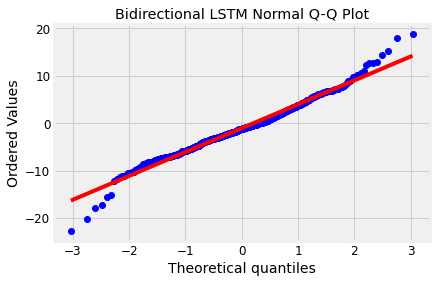

In [164]:
residuals = [y_val_uni[i]-val_bilstm_15_predict_result[i] for i in range(len(val_bilstm_15_predict_result))]
residuals = y_val_uni - val_bilstm_15_predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Bidirectional LSTM Normal Q-Q Plot")

#### Validation

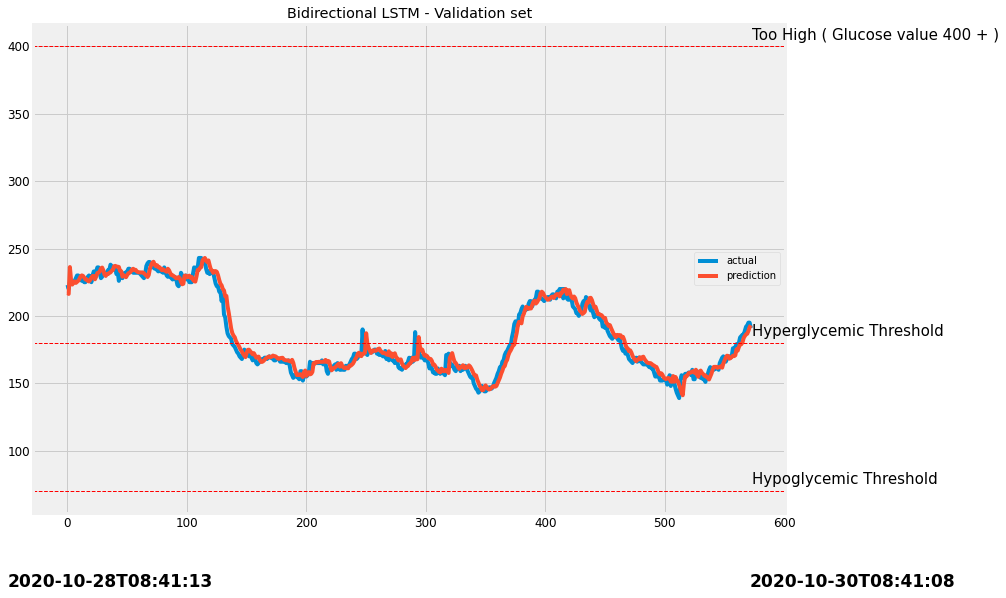

In [165]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(val_bilstm_15_predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(val_bilstm_15_predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(val_bilstm_15_predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(val_bilstm_15_predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Bidirectional LSTM - Validation set',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [166]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / Bidirectional LSTM - RMSE (60min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_bilstm_15 = RMSE(y_train_uni_origin,predict_result)

 Training set / Bidirectional LSTM - RMSE (60min) Training set :  11.196404250001352


#### Train

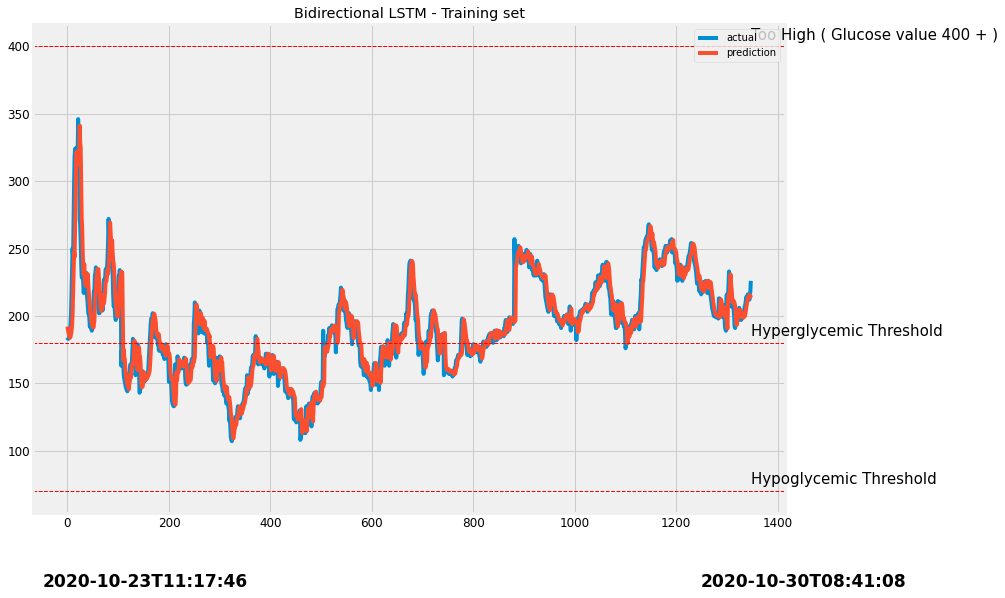

In [167]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Bidirectional LSTM - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### GRU - 15분

In [168]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [169]:
from keras.layers import GRU
model = Sequential()
model.add(GRU(50,activation='relu',input_shape=x_train_uni.shape[-2:]))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [170]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 50)                7950      
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 8,001
Trainable params: 8,001
Non-trainable params: 0
_________________________________________________________________


In [171]:
model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)

In [172]:
K.clear_session()

In [173]:
val_gru_15_predict_result = model.predict(x_val_uni,verbose=0)

In [174]:
for i in range(len(val_gru_15_predict_result)):
    if val_gru_15_predict_result[i] >= 400: 
        val_gru_15_predict_result[i]=400

In [175]:
val_gru_15_predict_result

array([[212.86801],
       [213.63972],
       [238.06361],
       [222.4219 ],
       [218.33223],
       [220.84875],
       [224.90572],
       [221.51418],
       [222.48264],
       [223.79462],
       [225.88463],
       [227.73735],
       [227.84381],
       [226.61185],
       [224.38892],
       [223.3    ],
       [224.29086],
       [222.51617],
       [222.47133],
       [224.4227 ],
       [226.82877],
       [227.78069],
       [226.683  ],
       [222.49237],
       [227.20634],
       [230.55525],
       [230.00883],
       [230.25955],
       [233.39127],
       [233.56026],
       [229.25159],
       [224.81029],
       [225.73662],
       [229.12941],
       [228.52112],
       [229.33148],
       [229.27951],
       [231.47409],
       [231.29276],
       [235.37103],
       [234.30739],
       [233.31503],
       [232.75648],
       [233.0493 ],
       [227.93956],
       [229.6937 ],
       [222.86041],
       [228.05034],
       [225.90485],
       [225.82065],


In [176]:
#predict_result

In [177]:
#predict_result

In [178]:

print('GRU - RMSE 15min : ',RMSE(y_val_uni_origin,val_gru_15_predict_result))
val_gru_15 = RMSE(y_val_uni_origin,val_gru_15_predict_result)
# 상한선 400일 때 RMSE - 38.30 
# 상한선 400 X - 38.63

GRU - RMSE 15min :  5.0902483214340775


#### 잔차

Text(0.5, 1.0, 'GRU Normal Q-Q Plot')

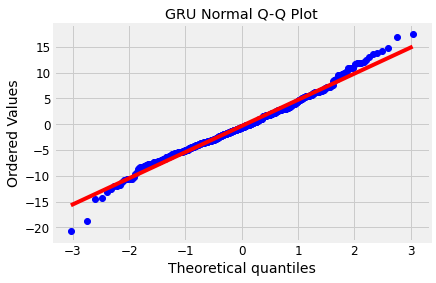

In [179]:
residuals = [y_val_uni[i]-val_gru_15_predict_result[i] for i in range(len(val_gru_15_predict_result))]
residuals = y_val_uni - val_gru_15_predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("GRU Normal Q-Q Plot")

#### Validation

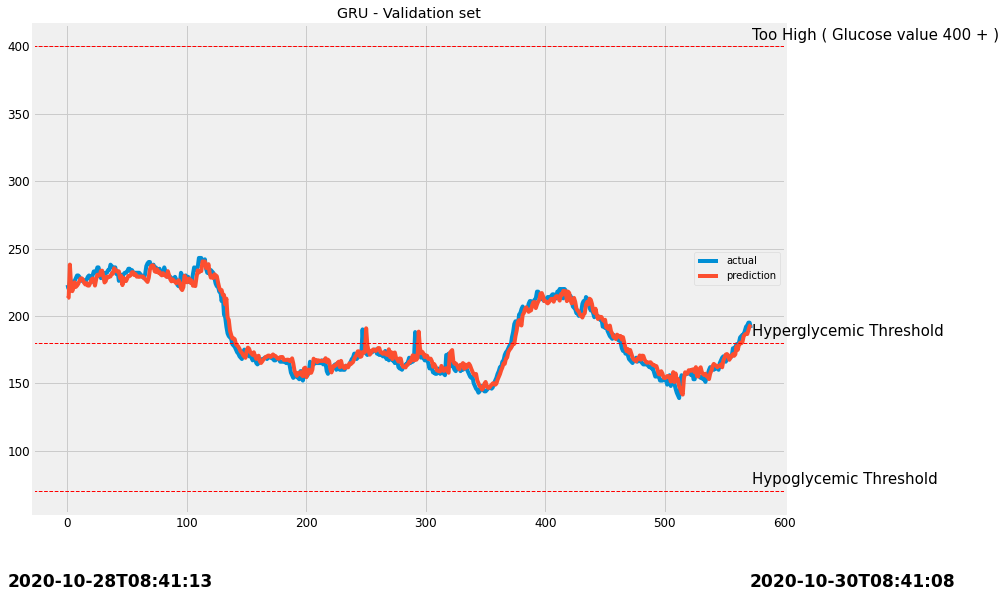

In [180]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(val_gru_15_predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(val_gru_15_predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(val_gru_15_predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(val_gru_15_predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('GRU - Validation set',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [181]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / GRU - RMSE (15min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_gru_15 =RMSE(y_train_uni_origin,predict_result)

 Training set / GRU - RMSE (15min) Training set :  10.618610980048691


#### Train

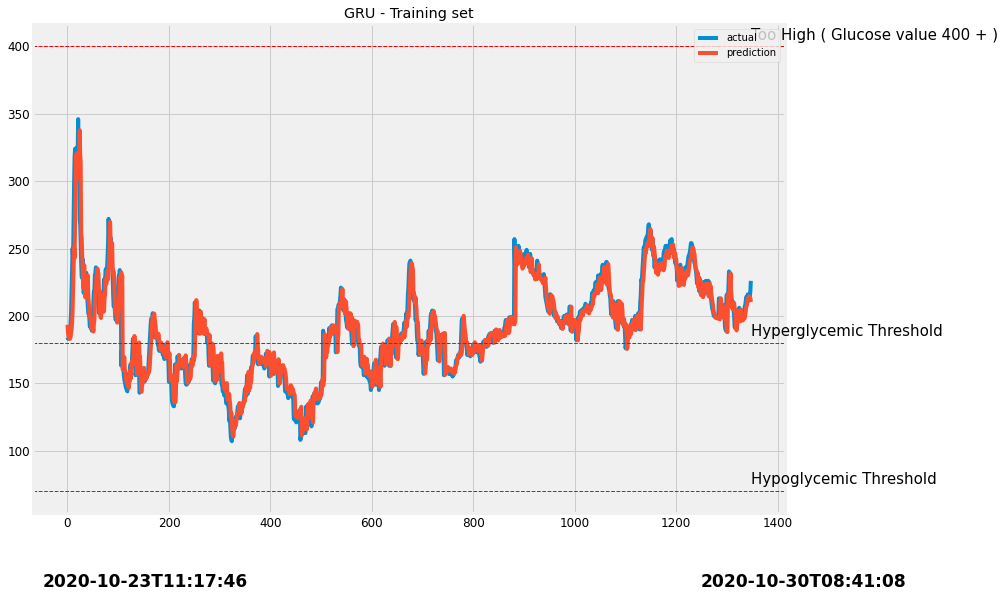

In [182]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('GRU - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

In [183]:
#from pandas import DataFrame
#residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
#residuals=DataFrame(residuals)
#residuals.hist()

In [184]:
#residuals.plot(kind='kde')

In [185]:
#residuals.plot()

In [186]:
#from statsmodels.graphics.gofplots import qqplot
#residuals=np.array(residuals)
#qqplot(residuals)

### Genetic Algorithm - 15Min

In [187]:
pip install geneticalgorithm2

In [188]:
from geneticalgorithm2 import geneticalgorithm2 as ga # for creating and running optimization model

from geneticalgorithm2 import Crossover, Mutations, Selection # classes for specific mutation and crossover behavior

from geneticalgorithm2 import Population_initializer # for creating better start population

from geneticalgorithm2 import np_lru_cache # for cache function (if u want)

from geneticalgorithm2 import plot_pop_scores # for plotting population scores, if u want

from geneticalgorithm2 import Callbacks # simple callbacks

from geneticalgorithm2 import Actions, ActionConditions, MiddleCallbacks # middle callbacks

In [189]:
val_rnn_15 = round(val_rnn_15,2)
val_lstm_15 = round(val_lstm_15,2)
val_stacklstm_15 = round(val_stacklstm_15,2)
val_bilstm_15 = round(val_bilstm_15,2)
val_gru_15 = round(val_gru_15,2)


In [190]:
#val_rnn_15_predict_result[:5]

In [191]:
#ex = val_rnn_15_predict_result * 0.2 + val_lstm_15_predict_result * 0.2 + val_slstm_15_predict_result * 0.2 + val_bilstm_15_predict_result * 0.2 + val_gru_15_predict_result * 0.2

In [192]:
#ex = val_rnn_15_predict_result * 0.3 + val_lstm_15_predict_result * 0.1 + val_slstm_15_predict_result * 0.14 + val_bilstm_15_predict_result * 0.11 + val_gru_15_predict_result * 0.35

In [193]:
# Baseline
#test_result = RMSE(y_val_uni_origin,ex)
#test_result

In [194]:
#test_result = 200 - RMSE(y_val_uni_origin,ex)
#test_result = 200 - RMSE(val_rnn_15_predict_result * 0.2 + val_lstm_15_predict_result * 0.2 + val_slstm_15_predict_result * 0.2 + val_bilstm_15_predict_result * 0.2 + val_gru_15_predict_result * 0.2,ex)


In [195]:
val_rnn_15_predict_result = np.asarray(val_rnn_15_predict_result)
val_lstm_15_predict_result = np.asarray(val_lstm_15_predict_result)
val_slstm_15_predict_result = np.asarray(val_slstm_15_predict_result)
val_bilstm_15_predict_result = np.asarray(val_bilstm_15_predict_result)
val_gru_15_predict_result = np.asarray(val_gru_15_predict_result)

In [196]:
def evaluate2(X):
  pen = 0 
  #coef = [0,0,0,0,0]
  ab=0
  result =0
  #result2 = 0
  #print(X)
  if sum(X) > 0.99 and sum(X) < 1:
    #print("\n ** Count ** ")
    #print(count)
    #sum(coef)
    #pen = 2000 - sum(list1 * coef[0] + list2 * coef[1] + # 400 = 혈당측정기에서 수집한 EGV의 최댓값이 400
    #             list3 * coef[2] + list4 * coef[3] +
    #             list5 * coef[4])
    #RMSE(y_val_uni_origin,predict_result)
    #result = mean_squared_error((y_val_uni_origin,(val_rnn_30_predict_result * X[0] + val_lstm_30_predict_result * X[1] +
    #             val_slstm_30_predict_result * X[2] + val_bilstm_30_predict_result * X[3] +
    #             val_gru_30_predict_result * X[4]))**0.5)
   # ab = val_rnn_30_predict_result * X[0] + val_lstm_30_predict_result * X[1] +val_slstm_30_predict_result * X[2] + val_bilstm_30_predict_result * X[3] + val_gru_30_predict_result * X[4]
   # print("\n ** A ** \n")
   # print(ab.shape)
    result = 30 - np.sqrt(mean_squared_error(val_rnn_15_predict_result * X[0] + val_lstm_15_predict_result * X[1] +val_slstm_15_predict_result * X[2] + 
                                val_bilstm_15_predict_result * X[3] + val_gru_15_predict_result * X[4],y_val_uni_origin))
    
    #result = 10 - mean_squared_error(y_val_uni_origin,abc) / test_result 
    #result2=(test_result*5) - np.sqrt(result)
    #test_result =  mean_squared_error(y_val_uni_origin,ex)
    #test_result

    #pen = RMSE(y_val_uni_origin,result)
    #pen = 200 - np.sqrt(y_val_uni_origin,(val_rnn_15_predict_result * (X[0] / 10000) + val_lstm_15_predict_result * (X[1] / 10000) +
    #             val_slstm_15_predict_result * (X[2] / 10000) + val_bilstm_15_predict_result * (X[3] / 10000) +
    #             val_gru_15_predict_result * (X[4] / 10000)))
    # np.sqrt(mean_squared_error(y_test,y_predict))
    print("\n ** B ** \n")
    print(X)
    #print()
    print("\n ** C ** \n")
    print(result)
  #return np.sum(X) + pen
    #count += 1 
  return -result
    
    

In [197]:
varbound2 = np.array([[0.05, 0.5]]*5)

In [198]:
algorithm_param = {'max_num_iteration': 25000,
                   'population_size':100,
                   'mutation_probability':0.1,
                   'elit_ratio': 0.01,
                   'crossover_probability': 0.5,
                   'parents_portion': 0.3,
                   'crossover_type':'uniform',
                   'selection_type': 'roulette',
                   'max_iteration_without_improv':None}

In [199]:
model1 = ga(function = evaluate2, dimension = 5, variable_type='real',variable_boundaries=varbound2,algorithm_parameters = algorithm_param)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 ** B ** 

[0.49997311 0.05071824 0.33343353 0.06159238 0.05052242]

 ** C ** 

25.10301851626764

 ** B ** 

[0.49997311 0.05071824 0.33343353 0.06159238 0.05052242]

 ** C ** 

25.10301851626764

 ** B ** 

[0.49997311 0.05320435 0.33343353 0.06159238 0.05052242]

 ** C ** 

25.080585382365857

 ** B ** 

[0.49997311 0.05071824 0.33343353 0.06159238 0.05052242]

 ** C ** 

25.10301851626764

 ** B ** 

[0.49997311 0.05071824 0.33343353 0.06159238 0.05052242]

 ** C ** 

25.10301851626764

 ** B ** 

[0.49997311 0.05320435 0.33343353 0.06159238 0.05052242]

 ** C ** 

25.080585382365857

 ** B ** 

[0.49997311 0.05071824 0.33343353 0.06159238 0.05052242]

 ** C ** 

25.10301851626764

 ** B ** 

[0.49997311 0.05071824 0.33343353 0.06159238 0.05052242]

 ** C ** 

25.10301851626764

 ** B ** 

[0.49997311 0.05071824 0.33343353 0.06159238 0.05052242]

 ** C ** 

25.10301851626764

 ** B ** 

[0.49997311 0.05071824 0.33343353 0.06159238 0.05052242]

 *

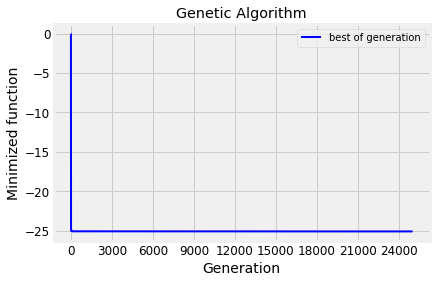

In [200]:
model1.run()

In [201]:
# RMSE 
optimized = val_rnn_15_predict_result * model1.output_dict['variable'][0] + val_lstm_15_predict_result *model1.output_dict['variable'][1] + val_slstm_15_predict_result * model1.output_dict['variable'][2] + val_bilstm_15_predict_result * model1.output_dict['variable'][3] + val_gru_15_predict_result * model1.output_dict['variable'][4]
optimized_rmse_15 =  RMSE(y_val_uni_origin,optimized)
optimized_rmse_15

4.89698148373236

In [202]:
optimized

array([[213.69286],
       [214.22568],
       [235.34613],
       [224.3143 ],
       [219.0636 ],
       [222.29102],
       [224.78395],
       [222.61586],
       [223.52347],
       [224.72055],
       [226.62631],
       [228.68002],
       [228.83812],
       [227.76927],
       [225.68007],
       [224.43033],
       [225.20831],
       [223.6974 ],
       [223.39908],
       [225.33612],
       [227.64258],
       [228.74576],
       [227.82567],
       [223.87105],
       [227.59288],
       [231.56248],
       [230.87856],
       [231.50114],
       [234.4709 ],
       [234.68987],
       [230.76889],
       [226.42564],
       [226.62064],
       [229.88365],
       [229.651  ],
       [230.3922 ],
       [230.58458],
       [232.40398],
       [232.5832 ],
       [236.24069],
       [235.71017],
       [234.57022],
       [234.2221 ],
       [234.3085 ],
       [229.62268],
       [230.44409],
       [224.78932],
       [227.90424],
       [227.55507],
       [226.56393],


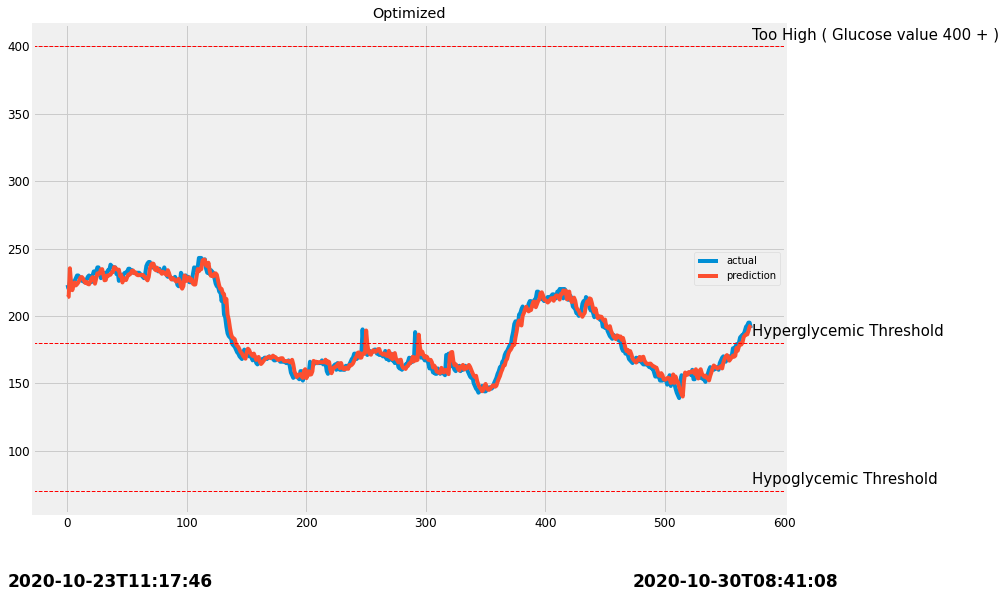

In [203]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(optimized,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(y_val_uni_origin),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(y_val_uni_origin),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(y_val_uni_origin),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Optimized',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(y_val_uni_origin)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

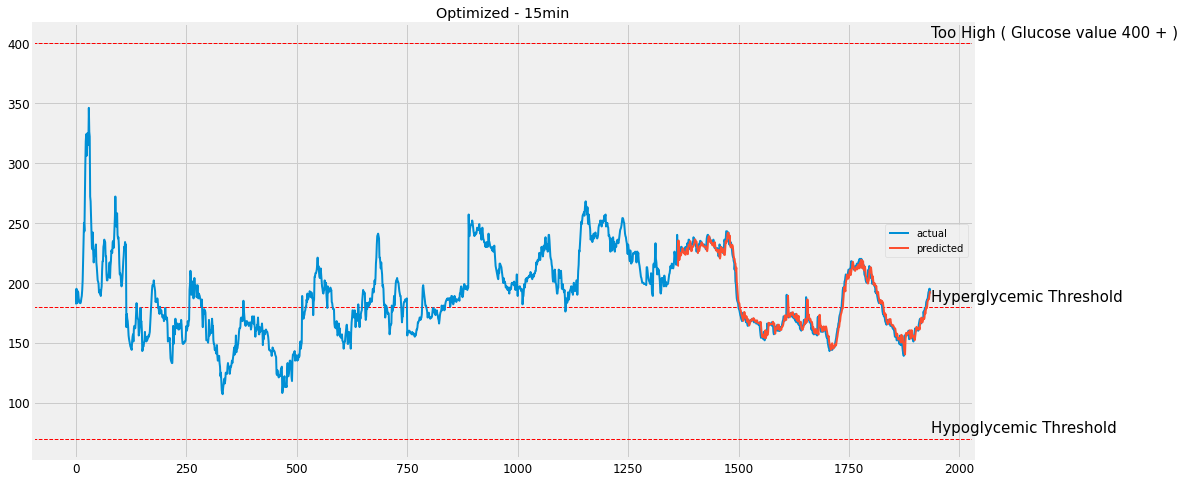

In [204]:
# Make a new dataframe of your prediction values
df_new = pd.DataFrame(df['Glucose'])
df_new.columns = ['rawseq']

# Retrieve index values
new_index = df_new['rawseq'].tail(len(optimized)).index

# Make a dataframe with your prediction values and your index
new_series = pd.DataFrame(index = new_index, data = optimized)

# Merge the dataframes
df_new = pd.merge(df_new, new_series, how = 'left', left_index=True, right_index=True)
df_new.columns = ['rawseq', 'optimized']

# And plot it
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))

plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)

plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(raw_seq),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(raw_seq),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(raw_seq),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Optimized - 15min',family='Times New Roman')
plt.plot(df_new['rawseq'],label='actual',linewidth=2)
plt.plot(df_new['optimized'], label='predicted',linewidth=2)
plt.legend(loc='best')
plt.show()

#### GA_Residual

Text(0.5, 1.0, '15Min GA Normal Q-Q Plot')

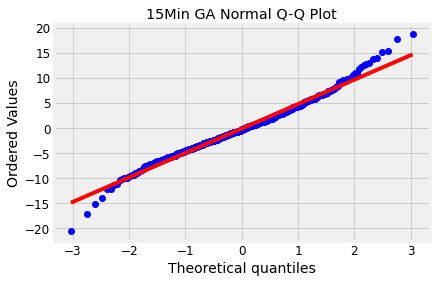

In [205]:
residuals = [y_val_uni_origin[i]-optimized[i] for i in range(len(optimized))]
residuals = y_val_uni_origin - optimized.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("15Min GA Normal Q-Q Plot")

Text(0.5, 1.0, '15Min GA Normal Q-Q Plot')

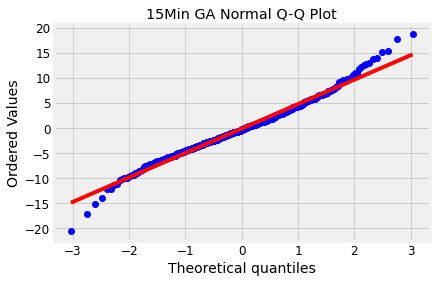

In [206]:
probplot(residuals,dist="norm",plot=plt)
plt.title("15Min GA Normal Q-Q Plot")

In [207]:
residuals=DataFrame(residuals)

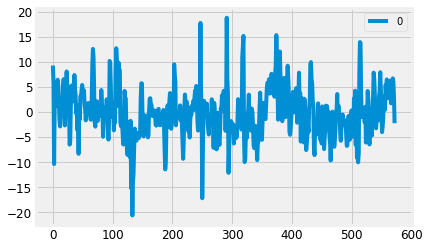

In [208]:
residuals.plot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fabbd4b4650>]],
      dtype=object)

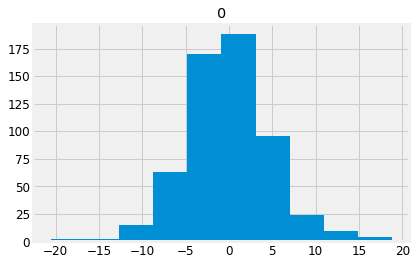

In [209]:

residuals.hist()

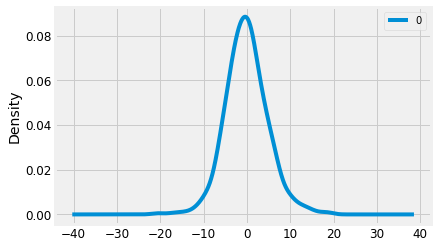

In [210]:
residuals.plot(kind='kde')

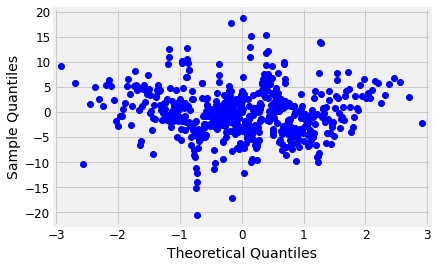

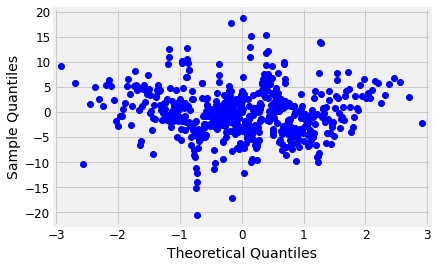

In [211]:
from statsmodels.graphics.gofplots import qqplot
residuals=np.array(residuals)
qqplot(residuals)

## 30분

In [212]:
# SG필터 테스트 
#import scipy.signal 

#yhat = scipy.signal.savgol_filter(raw_seq,15,5)
#plt.plot(raw_seq)
#plt.plot(yhat,color='red')
#plt.show()

In [213]:
#TRAIN_SPLIT=int(len(raw_seq)*0.7)
#uni_past_history=6
#uni_future_target=5
#x_train_uni,y_train_uni = uni_data(yhat,0,TRAIN_SPLIT,
#                                  uni_past_history,
#                                  uni_future_target)
#x_val_uni,y_val_uni=uni_data(yhat,TRAIN_SPLIT,None,
#                            uni_past_history,
#                            uni_future_target)



In [214]:
TRAIN_SPLIT=int(len(raw_seq)*0.7)
uni_past_history=6
uni_future_target=5
x_train_uni,y_train_uni = uni_data(raw_seq,0,TRAIN_SPLIT,
                                  uni_past_history,
                                  uni_future_target)
x_val_uni,y_val_uni=uni_data(raw_seq,TRAIN_SPLIT,None,
                            uni_past_history,
                            uni_future_target)

In [215]:
TRAIN_SPLIT=int(len(raw_seq)*0.7)
uni_past_history=6
uni_future_target=5
x_train_uni_origin,y_train_uni_origin = uni_data(raw_seq,0,TRAIN_SPLIT,
                                  uni_past_history,
                                  uni_future_target)
x_val_uni_origin,y_val_uni_origin=uni_data(raw_seq,TRAIN_SPLIT,None,
                            uni_past_history,
                            uni_future_target)



In [216]:
y_val_uni.shape


(570,)

In [217]:

x_val_uni.shape

(570, 6, 1)

In [218]:
x_train_uni[0]

array([[182],
       [195],
       [184],
       [183],
       [193],
       [192]])

In [219]:
df['Glucose'].head(15)

0     182.0
1     195.0
2     184.0
3     183.0
4     193.0
5     192.0
6     187.0
7     185.0
8     184.0
9     183.0
10    183.0
11    184.0
12    187.0
13    189.0
14    194.0
Name: Glucose, dtype: float64

In [220]:
y_train_uni[0]

184

### RNN - 30분

In [221]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [222]:
model = Sequential()
model.add(SimpleRNN(50,activation='relu',input_shape=x_train_uni.shape[-2:],return_sequences=False))
model.add(Dense(1))

In [223]:
model.compile(optimizer='adam',loss='mse')

In [224]:
model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)

In [225]:
val_rnn_30_predict_result = model.predict(x_val_uni,verbose=0)

In [226]:
K.clear_session()

In [227]:
predict_result = model.predict(x_val_uni,verbose=0)

In [228]:
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
# GA에 사용 
val_rnn_30_predict_result = predict_result

In [229]:
val_rnn_30_predict_result

array([[212.17305],
       [214.68053],
       [243.814  ],
       [223.14229],
       [220.08017],
       [223.08826],
       [222.78667],
       [224.53397],
       [224.59784],
       [224.75319],
       [227.48445],
       [229.96342],
       [229.48573],
       [228.04193],
       [225.31665],
       [224.11946],
       [225.59192],
       [223.44998],
       [223.9096 ],
       [226.17287],
       [228.43777],
       [229.83882],
       [228.26166],
       [223.1072 ],
       [229.11812],
       [232.38979],
       [231.66093],
       [232.89853],
       [235.18893],
       [235.01797],
       [230.51898],
       [225.48512],
       [226.59227],
       [230.6617 ],
       [230.19617],
       [231.66728],
       [230.8841 ],
       [233.07217],
       [233.14075],
       [237.76372],
       [236.12955],
       [234.80376],
       [234.57011],
       [234.14392],
       [228.64688],
       [231.47044],
       [222.8134 ],
       [229.85878],
       [227.43866],
       [226.61662],


In [230]:
y_val_uni_origin

array([226, 224, 225, 226, 228, 230, 230, 229, 227, 226, 227, 225, 225,
       227, 229, 230, 229, 225, 230, 233, 232, 233, 236, 236, 232, 228,
       229, 232, 231, 232, 232, 234, 234, 238, 237, 236, 236, 236, 231,
       233, 226, 231, 229, 228, 231, 232, 232, 233, 235, 235, 233, 234,
       232, 232, 232, 232, 232, 232, 231, 230, 229, 228, 231, 237, 239,
       240, 240, 236, 236, 238, 235, 236, 234, 233, 235, 233, 233, 232,
       236, 233, 230, 229, 230, 229, 228, 227, 228, 229, 227, 223, 222,
       224, 232, 230, 227, 229, 230, 227, 229, 225, 225, 225, 231, 236,
       234, 236, 236, 243, 243, 243, 239, 239, 242, 235, 232, 233, 231,
       234, 233, 232, 228, 224, 222, 222, 218, 218, 211, 215, 201, 199,
       192, 187, 185, 184, 183, 179, 178, 177, 175, 173, 172, 170, 169,
       168, 173, 175, 174, 172, 171, 170, 172, 169, 167, 169, 169, 165,
       164, 165, 166, 167, 168, 168, 169, 169, 168, 169, 170, 169, 169,
       168, 167, 167, 168, 168, 168, 166, 166, 166, 166, 166, 16

In [231]:
# Val set RMSE 
print(' Vanila RNN (Simple RNN) - RMSE (15min) : ',RMSE(y_val_uni_origin,predict_result))
val_rnn_30 = RMSE(y_val_uni_origin,predict_result)


 Vanila RNN (Simple RNN) - RMSE (15min) :  7.239979262648355


#### 잔차

Text(0.5, 1.0, 'Simple RNN Q-Q Plot')

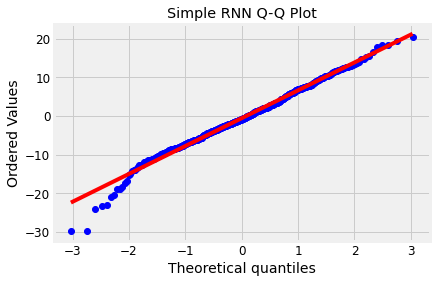

In [232]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Simple RNN Q-Q Plot")

#### Validation

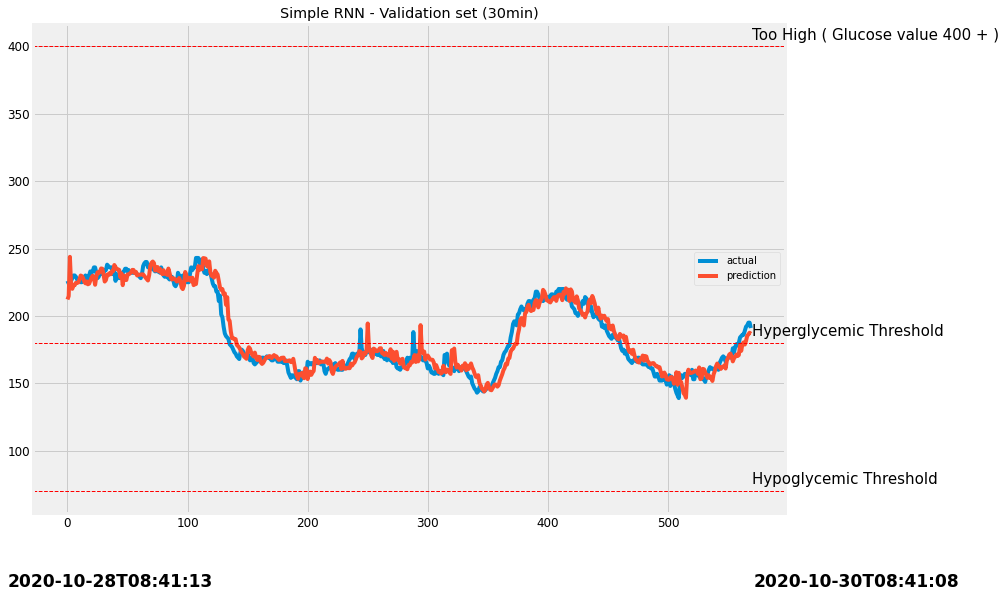

In [233]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Simple RNN - Validation set (30min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

Text(0.5, 1.0, 'Simple RNN 30min Normal Q-Q Plot')

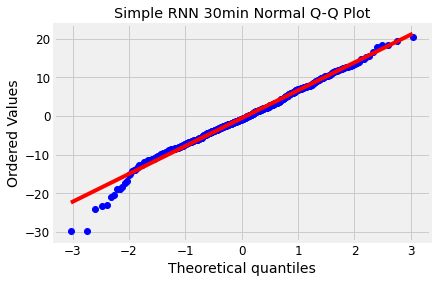

In [234]:
from pandas import DataFrame
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import probplot

#residuals=DataFrame(residuals)

residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)

#residuals

probplot(residuals,dist="norm",plot=plt)
plt.title("Simple RNN 30min Normal Q-Q Plot")

In [235]:
# 트레이닝셋 rmse 구하는 부분 
predict_result = model.predict(x_train_uni,verbose=0)
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400            
print(' Training set / Vanila RNN (Simple RNN) - RMSE (15min) : ',RMSE(y_train_uni_origin,predict_result))
train_rnn_30=RMSE(y_train_uni_origin,predict_result)

 Training set / Vanila RNN (Simple RNN) - RMSE (15min) :  15.805503027221246


#### Train

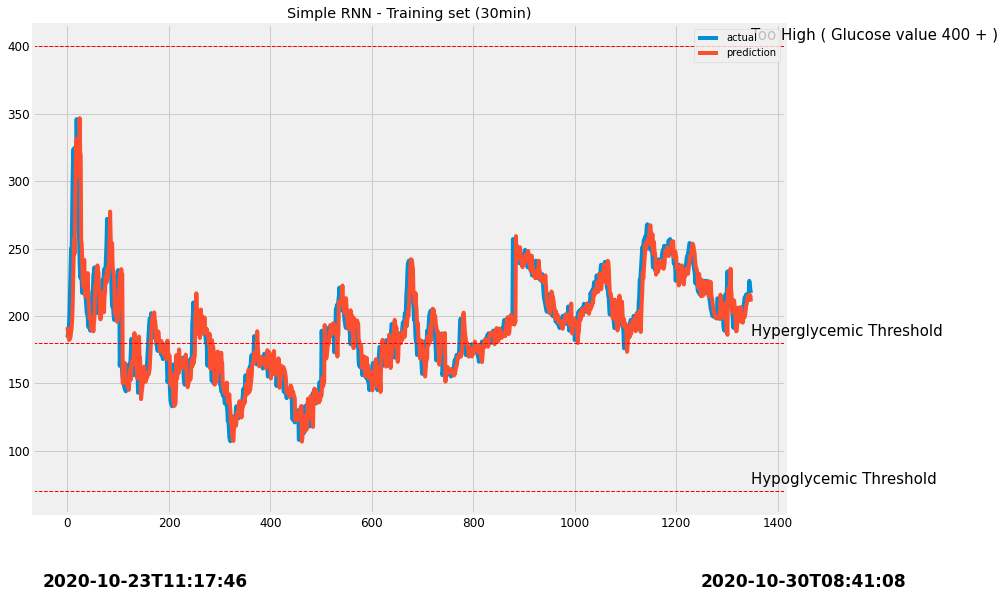

In [236]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Simple RNN - Training set (30min)',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### LSTM - 30분

In [237]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [238]:
model = Sequential()
model.add(LSTM(50,activation='relu',input_shape=x_train_uni.shape[-2:]))
model.add(Dense(1))


In [239]:
model.compile(optimizer='adam',loss='mse')

model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)
val_lstm_30_predict_result = model.predict(x_val_uni,verbose=0)
K.clear_session()

In [240]:
predict_result = model.predict(x_val_uni,verbose=0)

# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

#predict_result

print(' LSTM - RMSE (15min) : ',RMSE(y_val_uni_origin,predict_result))
val_lstm_30=RMSE(y_val_uni_origin,predict_result)

 LSTM - RMSE (15min) :  7.485279980285718


In [241]:
predict_result

array([[213.2128 ],
       [212.98753],
       [228.39546],
       [222.99849],
       [218.14767],
       [221.33243],
       [222.04063],
       [220.48364],
       [221.34686],
       [222.22417],
       [223.5463 ],
       [225.34708],
       [225.96622],
       [225.4891 ],
       [224.07019],
       [222.89464],
       [223.12988],
       [221.94461],
       [221.50993],
       [222.801  ],
       [224.43443],
       [225.58621],
       [225.40152],
       [222.7723 ],
       [225.0095 ],
       [227.80826],
       [227.7949 ],
       [228.62228],
       [230.93808],
       [231.48264],
       [229.05197],
       [225.7869 ],
       [225.32857],
       [227.03731],
       [226.91132],
       [227.59436],
       [228.02066],
       [229.24373],
       [229.68768],
       [232.32399],
       [232.67502],
       [231.9614 ],
       [231.86646],
       [231.75809],
       [228.44812],
       [228.61601],
       [224.447  ],
       [225.85716],
       [225.59398],
       [224.40518],


#### 잔차

Text(0.5, 1.0, 'LSTM Q-Q Plot')

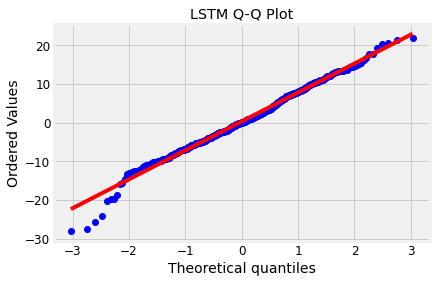

In [242]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("LSTM Q-Q Plot")

#### Validation

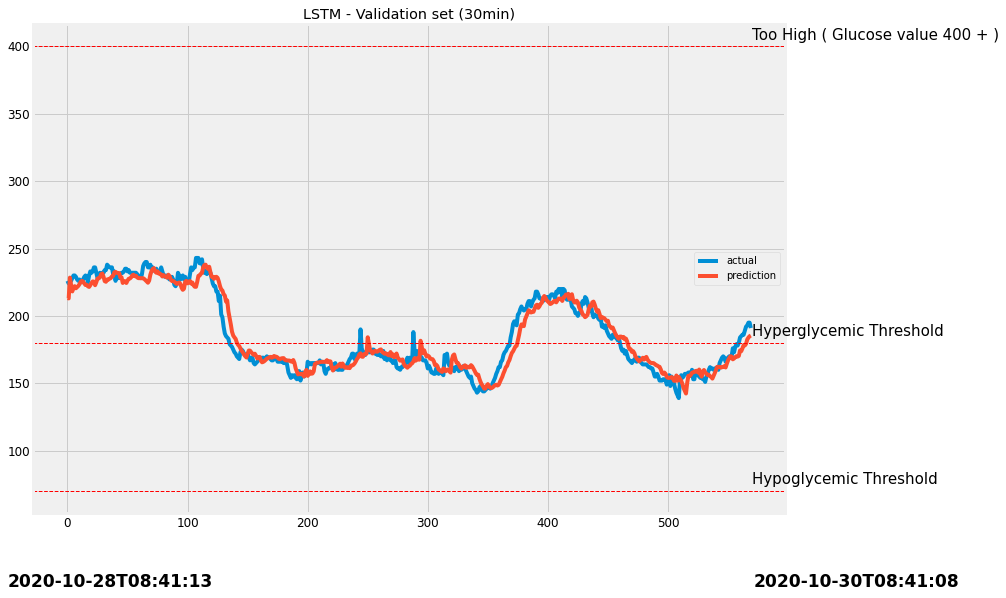

In [243]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('LSTM - Validation set (30min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [244]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' LSTM - RMSE (15min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_lstm_30 =RMSE(y_train_uni_origin,predict_result)

 LSTM - RMSE (15min) Training set :  16.080471046012544


#### Train

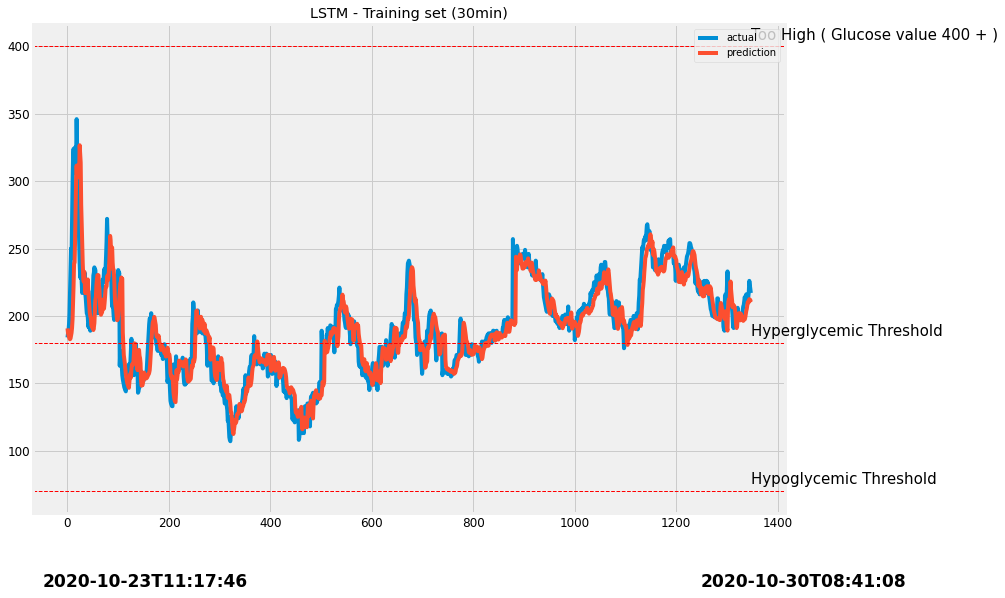

In [245]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('LSTM - Training set (30min)',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend()
plt.show()

### Stacked LSTM - 30분

In [246]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [247]:
model = Sequential()
#model.Flatten()
model.add(LSTM(50,activation='relu',return_sequences=True,input_shape=x_train_uni.shape[-2:]))
model.add(LSTM(50,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [248]:
model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)

In [249]:
K.clear_session()

In [250]:
val_slstm_30_predict_result = model.predict(x_val_uni,verbose=0)

In [251]:
predict_result = model.predict(x_val_uni,verbose=0)


for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

print(' Stacked LSTM - RMSE(15min) : ',RMSE(y_val_uni_origin,predict_result))
val_stacklstm_30 =RMSE(y_val_uni_origin,predict_result)

 Stacked LSTM - RMSE(15min) :  9.014258788760108


In [252]:
predict_result

array([[218.09189],
       [219.63177],
       [242.65663],
       [229.76707],
       [225.58533],
       [229.4749 ],
       [230.76459],
       [228.37186],
       [230.3266 ],
       [231.26381],
       [233.54321],
       [235.91052],
       [235.87167],
       [234.28113],
       [231.2655 ],
       [229.7188 ],
       [231.09361],
       [228.84276],
       [229.26141],
       [231.90967],
       [234.53313],
       [235.8192 ],
       [234.49294],
       [228.96036],
       [234.9815 ],
       [238.59212],
       [237.80505],
       [238.7724 ],
       [241.91754],
       [241.6083 ],
       [236.12437],
       [230.45294],
       [231.7822 ],
       [236.10446],
       [235.57986],
       [237.27658],
       [237.11047],
       [239.38486],
       [239.17534],
       [243.97542],
       [242.57889],
       [241.03223],
       [240.42227],
       [240.19484],
       [233.35788],
       [236.52591],
       [227.22737],
       [234.96262],
       [232.50519],
       [232.22379],


#### 잔차

Text(0.5, 1.0, 'Stacked LSTM Q-Q Plot')

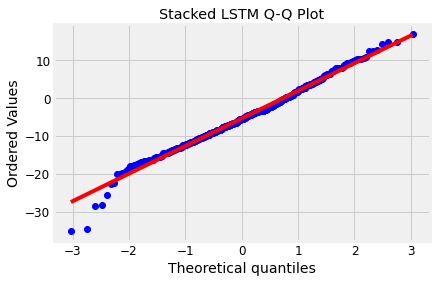

In [253]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Stacked LSTM Q-Q Plot")

#### Validation

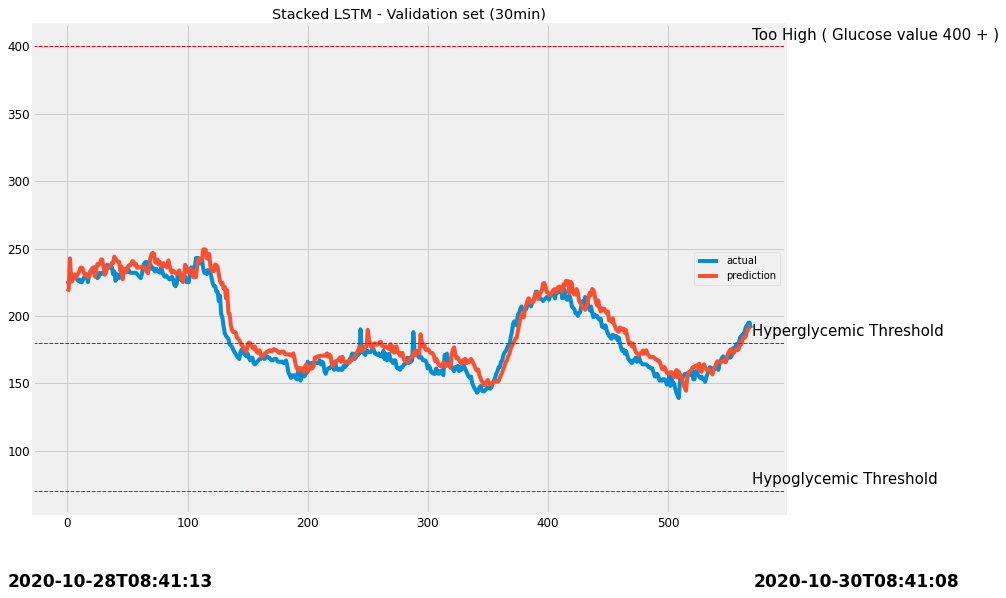

In [254]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Validation set (30min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [255]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / STACKED LSTM - RMSE (15min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_stacklstm_30 = RMSE(y_train_uni_origin,predict_result)

 Training set / STACKED LSTM - RMSE (15min) Training set :  16.683351400602653


#### Train

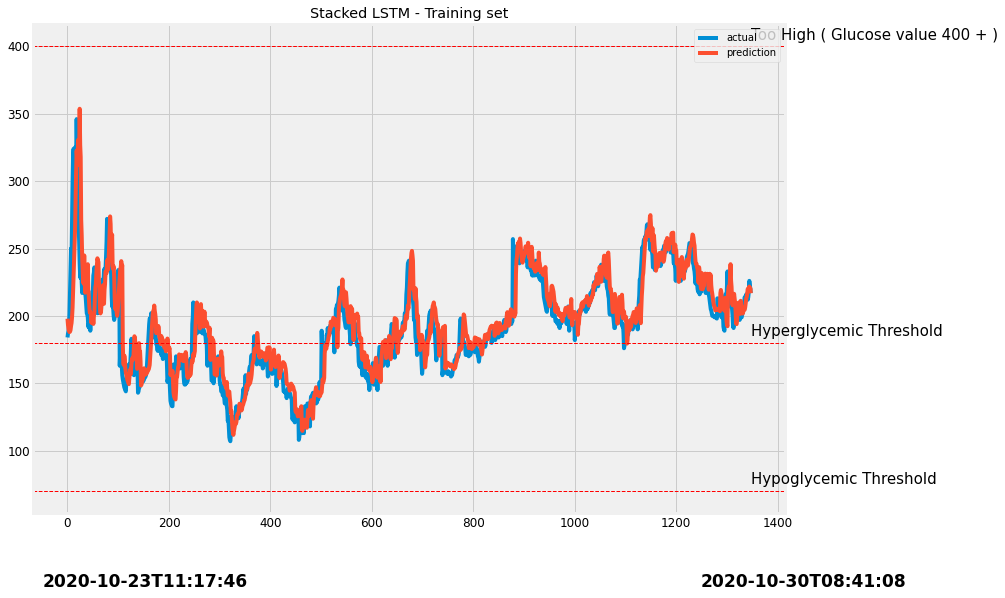

In [256]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### Bidirectional LSTM - 30분

In [257]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [258]:
from keras.layers import Bidirectional
model = Sequential()
model.add(Bidirectional(LSTM(50,activation='relu'),input_shape=x_train_uni.shape[-2:]))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [259]:
model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)

In [260]:
val_bilstm_30_predict_result = model.predict(x_val_uni,verbose=0)

In [261]:
K.clear_session()

In [262]:
predict_result = model.predict(x_val_uni,verbose=0)

for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

print('Bidirectional LSTM - RMSE : ',RMSE(y_val_uni_origin,predict_result))
val_bilstm_30 = RMSE(y_val_uni_origin,predict_result)

Bidirectional LSTM - RMSE :  7.282875105779101


In [263]:
predict_result

array([[211.51602],
       [212.0401 ],
       [233.21718],
       [218.7796 ],
       [215.1318 ],
       [222.68578],
       [221.95866],
       [218.55212],
       [221.32416],
       [222.28348],
       [223.95154],
       [225.80284],
       [225.62181],
       [224.6792 ],
       [222.71182],
       [221.73145],
       [222.6954 ],
       [220.36609],
       [220.72714],
       [222.98453],
       [224.80576],
       [225.57466],
       [224.58867],
       [220.67123],
       [226.28204],
       [228.47   ],
       [226.86842],
       [228.67154],
       [232.01245],
       [231.00166],
       [226.84201],
       [223.30229],
       [224.53128],
       [227.22568],
       [225.6903 ],
       [227.47083],
       [227.5365 ],
       [229.67143],
       [229.11038],
       [233.74712],
       [231.6618 ],
       [231.08125],
       [231.25479],
       [231.11911],
       [225.62578],
       [228.32153],
       [220.94894],
       [226.34753],
       [223.74597],
       [223.30588],


#### 잔차

Text(0.5, 1.0, 'Bidirectional LSTM Q-Q Plot')

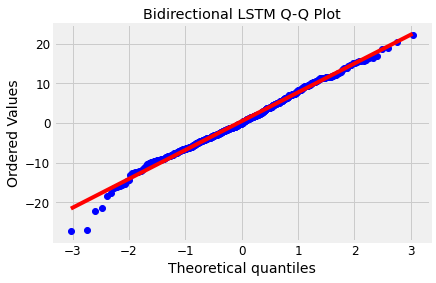

In [264]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Bidirectional LSTM Q-Q Plot")

#### Validation

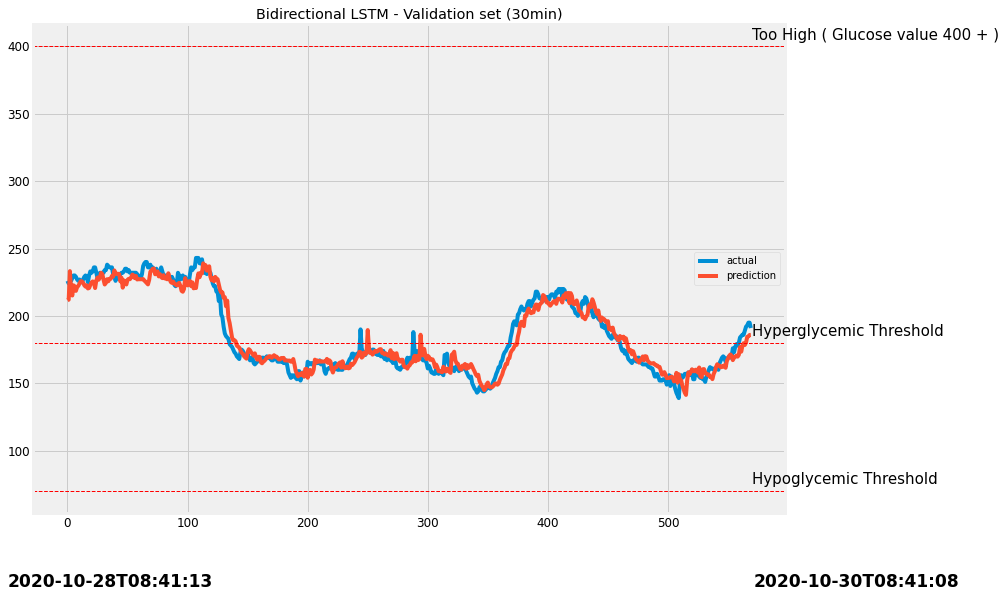

In [265]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Bidirectional LSTM - Validation set (30min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [266]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / Bidirectional LSTM - RMSE (30min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_bilstm_30 = RMSE(y_train_uni_origin,predict_result)

 Training set / Bidirectional LSTM - RMSE (30min) Training set :  15.663587703343088


#### Train

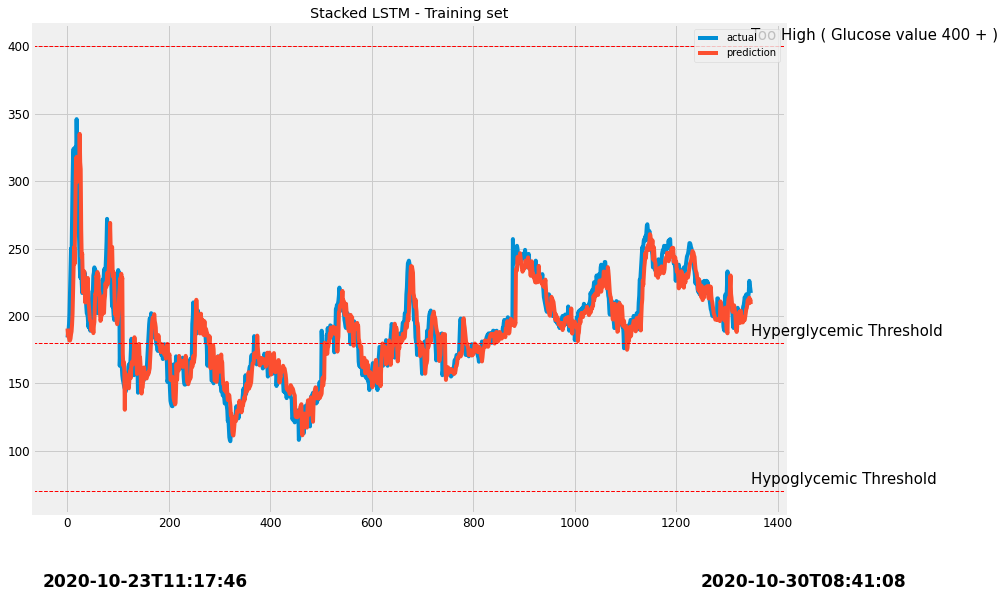

In [267]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### GRU - 30분

In [268]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [269]:
from keras.layers import GRU
model = Sequential()
model.add(GRU(50,activation='relu',input_shape=x_train_uni.shape[-2:]))
#model.add(GRU(50,activation=leaky_relu,input_shape=x_train_uni.shape[-2:]))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [270]:
model.summary()

model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)

K.clear_session()
val_gru_30_predict_result = model.predict(x_val_uni,verbose=0)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 50)                7950      
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 8,001
Trainable params: 8,001
Non-trainable params: 0
_________________________________________________________________


In [271]:
predict_result = model.predict(x_val_uni,verbose=0)

for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

#predict_result

#predict_result


print('GRU - RMSE 15min : ',RMSE(y_val_uni,predict_result))
val_gru_30 = RMSE(y_val_uni,predict_result)
# 상한선 400일 때 RMSE - 38.30 
# 상한선 400 X - 38.63

GRU - RMSE 15min :  7.54010240678155


In [272]:
predict_result

array([[212.0159 ],
       [212.76202],
       [235.3977 ],
       [221.0996 ],
       [215.8262 ],
       [221.16818],
       [222.80464],
       [219.88799],
       [221.15549],
       [222.38235],
       [224.08923],
       [225.962  ],
       [226.01552],
       [224.90808],
       [222.94186],
       [221.89355],
       [222.83188],
       [221.10861],
       [220.9611 ],
       [223.0083 ],
       [225.04086],
       [225.9279 ],
       [224.9786 ],
       [221.12056],
       [225.52252],
       [228.82057],
       [227.73842],
       [228.40364],
       [231.44138],
       [231.40863],
       [227.38579],
       [223.43068],
       [224.3503 ],
       [227.38345],
       [226.5942 ],
       [227.39537],
       [227.63036],
       [229.40819],
       [229.42169],
       [233.0484 ],
       [232.31259],
       [231.0673 ],
       [230.9717 ],
       [231.05193],
       [226.27391],
       [227.86198],
       [221.82985],
       [225.95187],
       [224.83687],
       [223.66933],


#### 잔차

Text(0.5, 1.0, 'GRU Q-Q Plot')

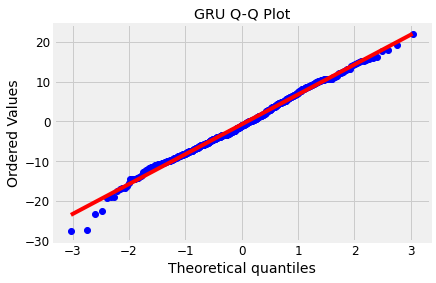

In [273]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("GRU Q-Q Plot")

#### Validation

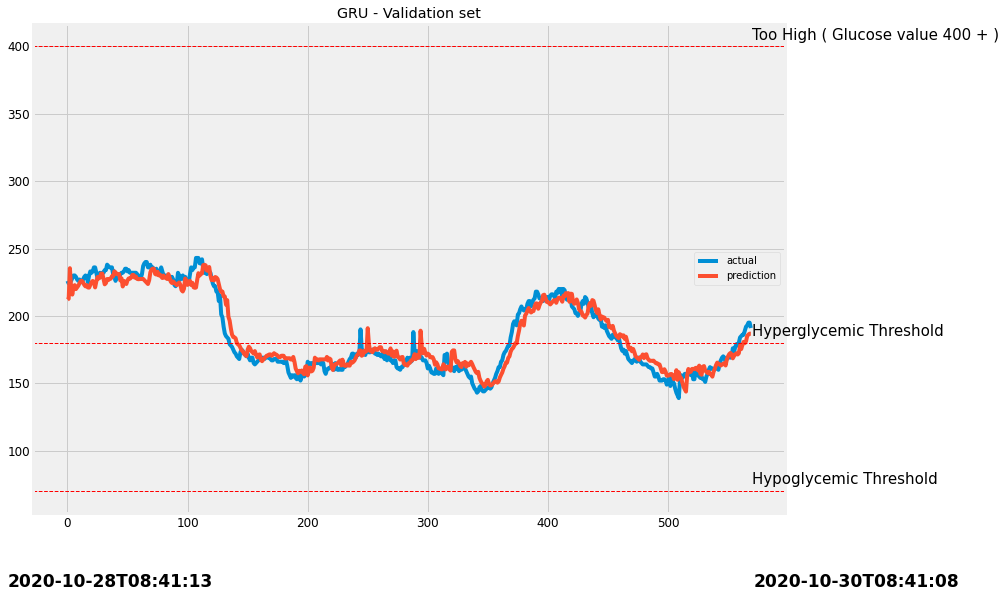

In [274]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('GRU - Validation set',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [275]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / GRU - RMSE (15min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_gru_30 =RMSE(y_train_uni_origin,predict_result)

 Training set / GRU - RMSE (15min) Training set :  15.644155207416164


#### Train

### GA

In [276]:
#ex = val_rnn_30_predict_result * 0.2 + val_lstm_30_predict_result * 0.2 + val_slstm_30_predict_result * 0.2 + val_bilstm_30_predict_result * 0.2 + val_gru_30_predict_result * 0.2

In [277]:
#ex2 = val_rnn_30_predict_result * 0.43578443     + val_lstm_30_predict_result *  0.07653674+ val_slstm_30_predict_result *  0.07391771 + val_bilstm_30_predict_result * 0.05667096+ val_gru_30_predict_result *0.34709233

In [278]:
#test_result =  RMSE(y_val_uni_origin,ex2)
#test_result

In [279]:
#test_result =  mean_squared_error(y_val_uni_origin,ex)
#test_result

In [280]:
#test_result * 2 - (1000 + test_result)

In [281]:
#result = (test_result*2) - (1000 + mean_squared_error(y_val_uni_origin,abc))

In [282]:
#mean_squared_error

In [283]:
val_rnn_30_predict_result = np.asarray(val_rnn_30_predict_result)
val_lstm_30_predict_result = np.asarray(val_lstm_30_predict_result)
val_slstm_30_predict_result = np.asarray(val_slstm_30_predict_result)
val_bilstm_30_predict_result = np.asarray(val_bilstm_30_predict_result)
val_gru_30_predict_result = np.asarray(val_gru_30_predict_result)

In [284]:
#def evaluate2(X):
#  pen = 0 
  #coef = [0,0,0,0,0]
#  result =0
  #result2 = 0
  #print(X)
#  if sum(X) > 0.99 and sum(X) < 1:
#    print("\n ** Count ** ")
    #print(count)
    #sum(coef)
    #pen = 2000 - sum(list1 * coef[0] + list2 * coef[1] + # 400 = 혈당측정기에서 수집한 EGV의 최댓값이 400
    #             list3 * coef[2] + list4 * coef[3] +
    #             list5 * coef[4])
    #RMSE(y_val_uni_origin,predict_result)
    #result = mean_squared_error((y_val_uni_origin,(val_rnn_30_predict_result * X[0] + val_lstm_30_predict_result * X[1] +
    #             val_slstm_30_predict_result * X[2] + val_bilstm_30_predict_result * X[3] +
    #             val_gru_30_predict_result * X[4]))**0.5)
 #   abc = val_rnn_30_predict_result * X[0] + val_lstm_30_predict_result * X[1] +val_slstm_30_predict_result * X[2] + val_bilstm_30_predict_result * X[3] + val_gru_30_predict_result * X[4]
  #  result = (test_result*2) - ((test_result/2) + mean_squared_error(y_val_uni_origin,abc))
    #result = 10 - mean_squared_error(y_val_uni_origin,abc) / test_result 
    #result2=(test_result*5) - np.sqrt(result)
    #test_result =  mean_squared_error(y_val_uni_origin,ex)
    #test_result

    #pen = RMSE(y_val_uni_origin,result)
    #pen = 200 - np.sqrt(y_val_uni_origin,(val_rnn_15_predict_result * (X[0] / 10000) + val_lstm_15_predict_result * (X[1] / 10000) +
    #             val_slstm_15_predict_result * (X[2] / 10000) + val_bilstm_15_predict_result * (X[3] / 10000) +
    #             val_gru_15_predict_result * (X[4] / 10000)))
    # np.sqrt(mean_squared_error(y_test,y_predict))
   # print("\n ** B ** \n")
    #print(X)
    #print()
    #print("\n ** C ** \n")
    #print(result)
  #return np.sum(X) + pen
    #count += 1 
  #return -result
    
    

In [285]:
def evaluate2(X):
  pen = 0 
  #coef = [0,0,0,0,0]
  ab=0
  result =0
  #result2 = 0
  #print(X)
  if sum(X) > 0.99 and sum(X) < 1:
    #print("\n ** Count ** ")
    #print(count)
    #sum(coef)
    #pen = 2000 - sum(list1 * coef[0] + list2 * coef[1] + # 400 = 혈당측정기에서 수집한 EGV의 최댓값이 400
    #             list3 * coef[2] + list4 * coef[3] +
    #             list5 * coef[4])
    #RMSE(y_val_uni_origin,predict_result)
    #result = mean_squared_error((y_val_uni_origin,(val_rnn_30_predict_result * X[0] + val_lstm_30_predict_result * X[1] +
    #             val_slstm_30_predict_result * X[2] + val_bilstm_30_predict_result * X[3] +
    #             val_gru_30_predict_result * X[4]))**0.5)
   # ab = val_rnn_30_predict_result * X[0] + val_lstm_30_predict_result * X[1] +val_slstm_30_predict_result * X[2] + val_bilstm_30_predict_result * X[3] + val_gru_30_predict_result * X[4]
   # print("\n ** A ** \n")
   # print(ab.shape)
    result = 50 - np.sqrt(mean_squared_error(val_rnn_30_predict_result * X[0] + val_lstm_30_predict_result * X[1] +val_slstm_30_predict_result * X[2] + 
                                val_bilstm_30_predict_result * X[3] + val_gru_30_predict_result * X[4],y_val_uni_origin))
    
    #result = 10 - mean_squared_error(y_val_uni_origin,abc) / test_result 
    #result2=(test_result*5) - np.sqrt(result)
    #test_result =  mean_squared_error(y_val_uni_origin,ex)
    #test_result

    #pen = RMSE(y_val_uni_origin,result)
    #pen = 200 - np.sqrt(y_val_uni_origin,(val_rnn_15_predict_result * (X[0] / 10000) + val_lstm_15_predict_result * (X[1] / 10000) +
    #             val_slstm_15_predict_result * (X[2] / 10000) + val_bilstm_15_predict_result * (X[3] / 10000) +
    #             val_gru_15_predict_result * (X[4] / 10000)))
    # np.sqrt(mean_squared_error(y_test,y_predict))
    print("\n ** B ** \n")
    print(X)
    #print()
    print("\n ** C ** \n")
    print(result)
  #return np.sum(X) + pen
    #count += 1 
  return -result
    
    

In [286]:
#abc.shape

In [287]:
#y_val_uni_origin.shape

In [288]:
#val_rnn_30_predict_result.shape

In [289]:
#abc = val_rnn_30_predict_result * 0.2 + val_lstm_30_predict_result * 0.2 + val_slstm_30_predict_result * 0.2 + val_bilstm_30_predict_result * 0.2 +val_gru_30_predict_result * 0.2
              

In [290]:
#get = mean_squared_error(y_val_uni_origin,abc)

In [291]:
#test_result*2 - mean_squared_error(y_val_uni_origin,abc)

In [292]:
#varbound = np.array([[500,5000]]*5)

In [293]:
varbound2 = np.array([[0.05, 0.5]]*5)

In [294]:
algorithm_param = {'max_num_iteration': 25000,
                   'population_size':100,
                   'mutation_probability':0.1,
                   'elit_ratio': 0.01,
                   'crossover_probability': 0.5,
                   'parents_portion': 0.3,
                   'crossover_type':'uniform',
                   'selection_type': 'roulette',
                   'max_iteration_without_improv':None}

In [295]:
#model = ga(function = evaluate, dimension = 5, variable_type='int',variable_boundaries=varbound,algorithm_parameters = algorithm_param)

In [296]:
model2 = ga(function = evaluate2, dimension = 5, variable_type='real',variable_boundaries=varbound2,algorithm_parameters = algorithm_param)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 ** B ** 

[0.39445827 0.05000324 0.29787724 0.19821593 0.05042952]

 ** C ** 

42.813529793842974

 ** B ** 

[0.39445827 0.05000324 0.29787724 0.19821593 0.05042952]

 ** C ** 

42.813529793842974

 ** B ** 

[0.39445827 0.05000324 0.29787724 0.19821593 0.05488414]

 ** C ** 

42.76399456846161

 ** B ** 

[0.39445827 0.05000324 0.29696684 0.19821593 0.05488414]

 ** C ** 

42.78231911510222

 ** B ** 

[0.39445827 0.05000324 0.29787724 0.19821593 0.05042952]

 ** C ** 

42.813529793842974

 ** B ** 

[0.39445827 0.05000324 0.29787724 0.19821593 0.05042952]

 ** C ** 

42.813529793842974

 ** B ** 

[0.39445827 0.05000324 0.29787724 0.19821593 0.05042952]

 ** C ** 

42.813529793842974

 ** B ** 

[0.39445827 0.05000324 0.29787724 0.19556272 0.05490445]

 ** C ** 

42.804550994284625

 ** B ** 

[0.39445827 0.05000324 0.29787724 0.19821593 0.05042952]

 ** C ** 

42.813529793842974

 ** B ** 

[0.39445827 0.05000324 0.29787724 0.19821593 0.05042952

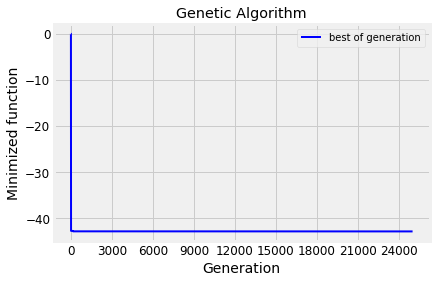

In [297]:
model2.run()

In [298]:
# RMSE 
optimized = val_rnn_30_predict_result * model2.output_dict['variable'][0] + val_lstm_30_predict_result *model2.output_dict['variable'][1] + val_slstm_30_predict_result * model2.output_dict['variable'][2] + val_bilstm_30_predict_result * model2.output_dict['variable'][3] + val_gru_30_predict_result * model2.output_dict['variable'][4]
optimized_rmse_30 =  RMSE(y_val_uni_origin,optimized)
optimized_rmse_30

7.186470206157027

In [299]:
optimized

array([[211.93707],
       [213.5151 ],
       [237.97519],
       [222.12889],
       [218.44383],
       [222.71497],
       [222.954  ],
       [222.0303 ],
       [223.29434],
       [223.93066],
       [226.16983],
       [228.40431],
       [228.20209],
       [226.89224],
       [224.35886],
       [223.11992],
       [224.36044],
       [222.23717],
       [222.58557],
       [224.88242],
       [227.10248],
       [228.29297],
       [227.02324],
       [222.23946],
       [227.85008],
       [230.95609],
       [230.06143],
       [231.2701 ],
       [234.04163],
       [233.70732],
       [229.15019],
       [224.41081],
       [225.51054],
       [229.17575],
       [228.48541],
       [229.9986 ],
       [229.68639],
       [231.80096],
       [231.67728],
       [236.16446],
       [234.67097],
       [233.47372],
       [233.2247 ],
       [232.96057],
       [227.26031],
       [229.94058],
       [221.78189],
       [228.21364],
       [225.94191],
       [225.32831],


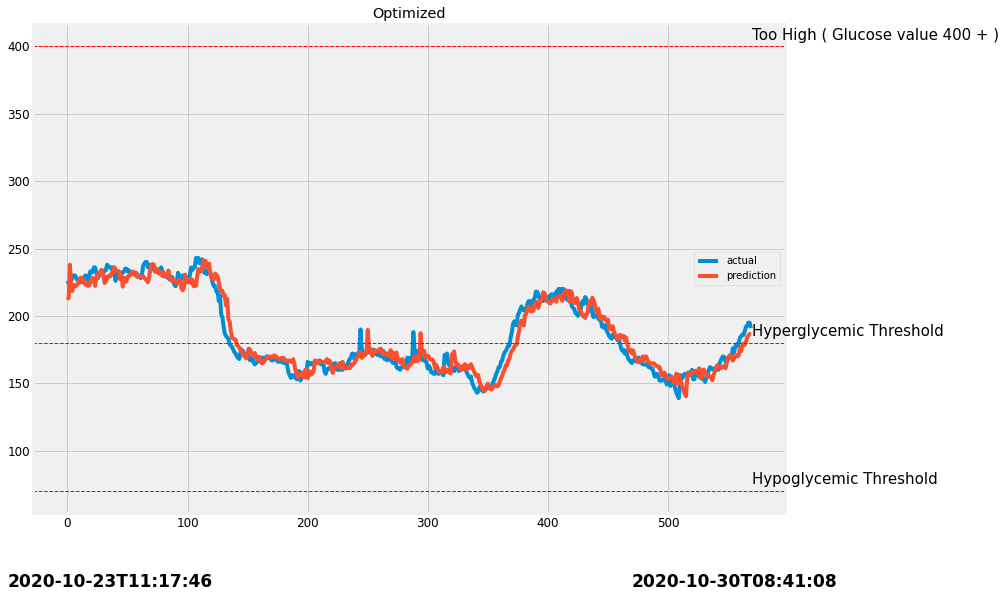

In [300]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(optimized,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(y_val_uni_origin),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(y_val_uni_origin),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(y_val_uni_origin),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Optimized',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(y_val_uni_origin)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

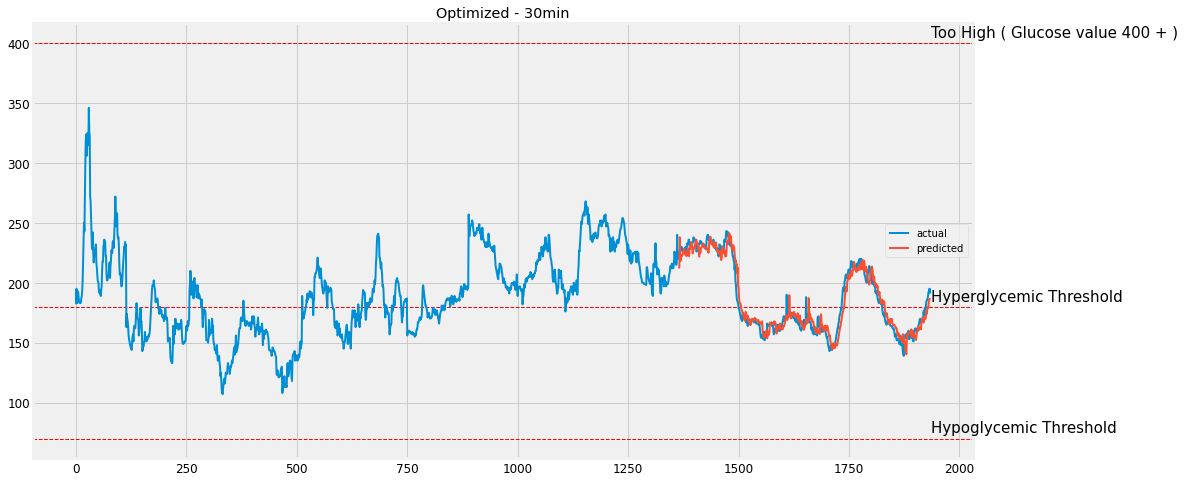

In [301]:
# Make a new dataframe of your prediction values
df_new = pd.DataFrame(df['Glucose'])
df_new.columns = ['rawseq']

# Retrieve index values
new_index = df_new['rawseq'].tail(len(optimized)).index

# Make a dataframe with your prediction values and your index
new_series = pd.DataFrame(index = new_index, data = optimized)

# Merge the dataframes
df_new = pd.merge(df_new, new_series, how = 'left', left_index=True, right_index=True)
df_new.columns = ['rawseq', 'optimized']

# And plot it
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))

plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)

plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(raw_seq),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(raw_seq),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(raw_seq),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Optimized - 30min',family='Times New Roman')
plt.plot(df_new['rawseq'],label='actual',linewidth=2)
plt.plot(df_new['optimized'], label='predicted',linewidth=2)
plt.legend(loc='best')
plt.show()

#### GA_Residual

Text(0.5, 1.0, '30Min GA Normal Q-Q Plot')

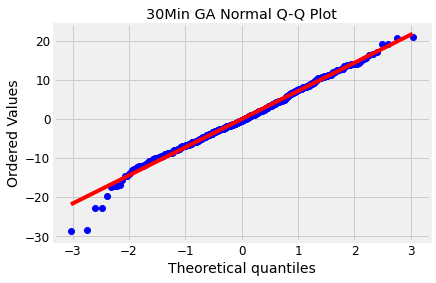

In [302]:
residuals = [y_val_uni_origin[i]-optimized[i] for i in range(len(optimized))]
residuals = y_val_uni_origin - optimized.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("30Min GA Normal Q-Q Plot")

Text(0.5, 1.0, '30Min GA Normal Q-Q Plot')

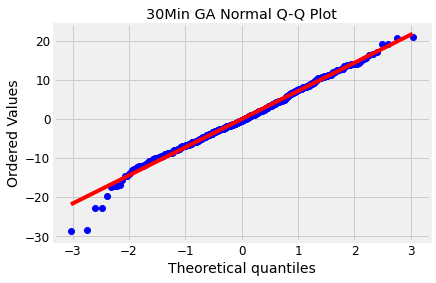

In [303]:
probplot(residuals,dist="norm",plot=plt)
plt.title("30Min GA Normal Q-Q Plot")

In [304]:
residuals=DataFrame(residuals)

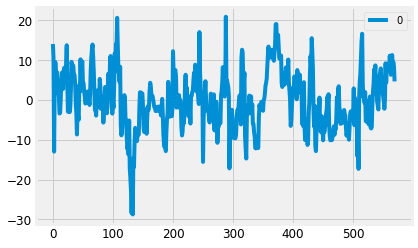

In [305]:
residuals.plot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fabbd216590>]],
      dtype=object)

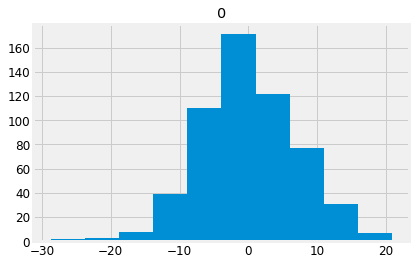

In [306]:

residuals.hist()

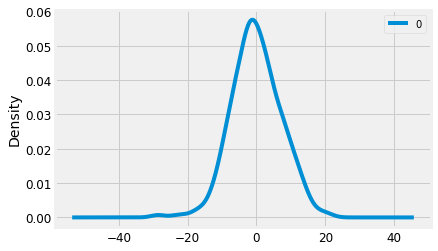

In [307]:
residuals.plot(kind='kde')

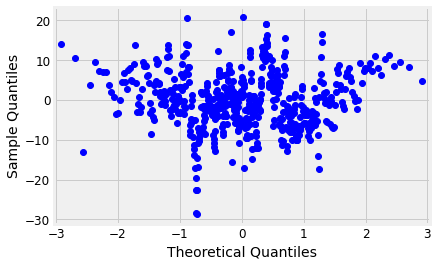

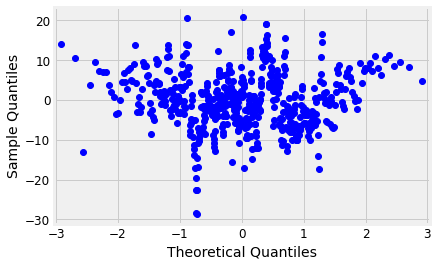

In [308]:
from statsmodels.graphics.gofplots import qqplot
residuals=np.array(residuals)
qqplot(residuals)

In [309]:
model2.output_dict

{'function': -42.813529793842974,
 'last_generation': {'scores': array([-42.81352979, -42.81352979, -42.81352979, -42.81352979,
         -42.81352979, -42.81352979, -42.81352979, -42.81352979,
         -42.81352979, -42.81352979, -42.81352979, -42.81352979,
         -42.81352979, -42.81352979, -42.81352979, -42.81352979,
         -42.81352979, -42.81352979, -42.81352979, -42.81352979,
         -42.81352979, -42.81352979, -42.81352979, -42.81352979,
         -42.81352979, -42.81352979, -42.81352979, -42.81352979,
         -42.81352979, -42.81352979, -42.81352979, -42.81352979,
         -42.81352979, -42.81352979, -42.81352979, -42.81352979,
         -42.81352979, -42.81352979, -42.81352979, -42.81352979,
         -42.81352979, -42.81352979, -42.81352979, -42.81352979,
         -42.81352979, -42.81352979, -42.81352979, -42.81352979,
         -42.81352979, -42.81352979, -42.81352979, -42.81352979,
         -42.81352979, -42.81352979, -42.81352979, -42.81352979,
         -42.81352979, -42.

In [310]:
#model2.output_dict['variable'][0]


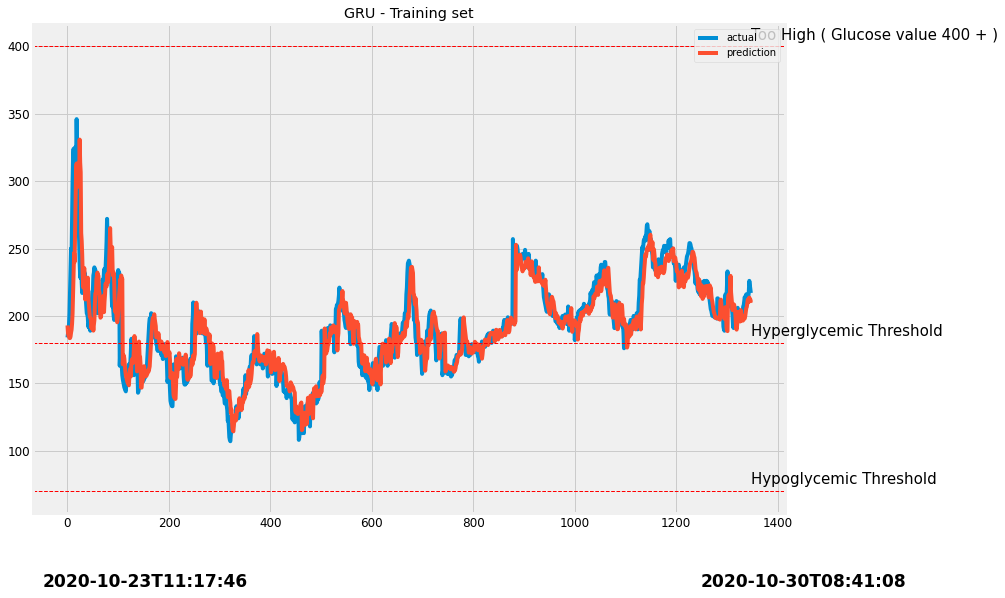

In [311]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('GRU - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

## 60분

In [312]:
# SG필터 테스트 
#import scipy.signal 

#yhat = scipy.signal.savgol_filter(raw_seq,15,5)
#plt.plot(raw_seq)
#plt.plot(yhat,color='red')
#plt.show()

In [313]:
#TRAIN_SPLIT=int(len(raw_seq)*0.7)
#uni_past_history=6
#uni_future_target=11
#x_train_uni,y_train_uni = uni_data(yhat,0,TRAIN_SPLIT,
#                                  uni_past_history,
#                                  uni_future_target)
#x_val_uni,y_val_uni=uni_data(yhat,TRAIN_SPLIT,None,
#                            uni_past_history,
#                            uni_future_target)



In [314]:
TRAIN_SPLIT=int(len(raw_seq)*0.7)
uni_past_history=6
uni_future_target=11
x_train_uni,y_train_uni = uni_data(raw_seq,0,TRAIN_SPLIT,
                                  uni_past_history,
                                  uni_future_target)
x_val_uni,y_val_uni=uni_data(raw_seq,TRAIN_SPLIT,None,
                            uni_past_history,
                            uni_future_target)

In [315]:
TRAIN_SPLIT=int(len(raw_seq)*0.7)
uni_past_history=6
uni_future_target=11
x_train_uni_origin,y_train_uni_origin = uni_data(raw_seq,0,TRAIN_SPLIT,
                                  uni_past_history,
                                  uni_future_target)
x_val_uni_origin,y_val_uni_origin=uni_data(raw_seq,TRAIN_SPLIT,None,
                            uni_past_history,
                            uni_future_target)



In [316]:
x_train_uni[0]

array([[182],
       [195],
       [184],
       [183],
       [193],
       [192]])

In [317]:
y_train_uni[0]

232

In [318]:
df['Glucose'].head(20)

0     182.0
1     195.0
2     184.0
3     183.0
4     193.0
5     192.0
6     187.0
7     185.0
8     184.0
9     183.0
10    183.0
11    184.0
12    187.0
13    189.0
14    194.0
15    202.0
16    218.0
17    232.0
18    250.0
19    243.0
Name: Glucose, dtype: float64

### RNN - 60분

In [319]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [320]:
model = Sequential()
model.add(SimpleRNN(50,activation='relu',input_shape=x_train_uni.shape[-2:])) # recurrent_dropout=0.2
model.add(Dense(1))

model.compile(optimizer='adam',loss='mse')

model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)
K.clear_session()

In [321]:
val_rnn_60_predict_result = model.predict(x_val_uni,verbose=0)

In [322]:
predict_result = model.predict(x_val_uni,verbose=0)

# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

# Val set RMSE 
print(' Vanila RNN (Simple RNN) - RMSE (15min) : ',RMSE(y_val_uni_origin,predict_result))
val_rnn_60 = RMSE(y_val_uni_origin,predict_result)


 Vanila RNN (Simple RNN) - RMSE (15min) :  11.776829323796075


In [323]:
predict_result

array([[209.20502],
       [211.69315],
       [228.31592],
       [220.6522 ],
       [209.65233],
       [214.88806],
       [218.32266],
       [220.16966],
       [218.96642],
       [219.20506],
       [222.06665],
       [224.11133],
       [223.85164],
       [222.78761],
       [220.82903],
       [219.97136],
       [221.18509],
       [220.23994],
       [219.77745],
       [221.01195],
       [223.06207],
       [224.34534],
       [223.04248],
       [219.27094],
       [222.51346],
       [226.6857 ],
       [226.52711],
       [226.61407],
       [227.87282],
       [229.38393],
       [226.5026 ],
       [221.86952],
       [222.12648],
       [226.05342],
       [226.22386],
       [226.25632],
       [225.34418],
       [227.03119],
       [227.91371],
       [230.66277],
       [230.64922],
       [229.28464],
       [228.93869],
       [228.98524],
       [226.0058 ],
       [226.34003],
       [221.49258],
       [224.35414],
       [224.38776],
       [222.67915],


In [324]:
y_val_uni_origin

array([230, 229, 227, 226, 227, 225, 225, 227, 229, 230, 229, 225, 230,
       233, 232, 233, 236, 236, 232, 228, 229, 232, 231, 232, 232, 234,
       234, 238, 237, 236, 236, 236, 231, 233, 226, 231, 229, 228, 231,
       232, 232, 233, 235, 235, 233, 234, 232, 232, 232, 232, 232, 232,
       231, 230, 229, 228, 231, 237, 239, 240, 240, 236, 236, 238, 235,
       236, 234, 233, 235, 233, 233, 232, 236, 233, 230, 229, 230, 229,
       228, 227, 228, 229, 227, 223, 222, 224, 232, 230, 227, 229, 230,
       227, 229, 225, 225, 225, 231, 236, 234, 236, 236, 243, 243, 243,
       239, 239, 242, 235, 232, 233, 231, 234, 233, 232, 228, 224, 222,
       222, 218, 218, 211, 215, 201, 199, 192, 187, 185, 184, 183, 179,
       178, 177, 175, 173, 172, 170, 169, 168, 173, 175, 174, 172, 171,
       170, 172, 169, 167, 169, 169, 165, 164, 165, 166, 167, 168, 168,
       169, 169, 168, 169, 170, 169, 169, 168, 167, 167, 168, 168, 168,
       166, 166, 166, 166, 166, 165, 165, 167, 163, 158, 156, 15

#### 잔차

In [325]:
y_val_uni_origin

array([230, 229, 227, 226, 227, 225, 225, 227, 229, 230, 229, 225, 230,
       233, 232, 233, 236, 236, 232, 228, 229, 232, 231, 232, 232, 234,
       234, 238, 237, 236, 236, 236, 231, 233, 226, 231, 229, 228, 231,
       232, 232, 233, 235, 235, 233, 234, 232, 232, 232, 232, 232, 232,
       231, 230, 229, 228, 231, 237, 239, 240, 240, 236, 236, 238, 235,
       236, 234, 233, 235, 233, 233, 232, 236, 233, 230, 229, 230, 229,
       228, 227, 228, 229, 227, 223, 222, 224, 232, 230, 227, 229, 230,
       227, 229, 225, 225, 225, 231, 236, 234, 236, 236, 243, 243, 243,
       239, 239, 242, 235, 232, 233, 231, 234, 233, 232, 228, 224, 222,
       222, 218, 218, 211, 215, 201, 199, 192, 187, 185, 184, 183, 179,
       178, 177, 175, 173, 172, 170, 169, 168, 173, 175, 174, 172, 171,
       170, 172, 169, 167, 169, 169, 165, 164, 165, 166, 167, 168, 168,
       169, 169, 168, 169, 170, 169, 169, 168, 167, 167, 168, 168, 168,
       166, 166, 166, 166, 166, 165, 165, 167, 163, 158, 156, 15

In [326]:
val_rnn_60_predict_result

array([[209.20502],
       [211.69315],
       [228.31592],
       [220.6522 ],
       [209.65233],
       [214.88806],
       [218.32266],
       [220.16966],
       [218.96642],
       [219.20506],
       [222.06665],
       [224.11133],
       [223.85164],
       [222.78761],
       [220.82903],
       [219.97136],
       [221.18509],
       [220.23994],
       [219.77745],
       [221.01195],
       [223.06207],
       [224.34534],
       [223.04248],
       [219.27094],
       [222.51346],
       [226.6857 ],
       [226.52711],
       [226.61407],
       [227.87282],
       [229.38393],
       [226.5026 ],
       [221.86952],
       [222.12648],
       [226.05342],
       [226.22386],
       [226.25632],
       [225.34418],
       [227.03119],
       [227.91371],
       [230.66277],
       [230.64922],
       [229.28464],
       [228.93869],
       [228.98524],
       [226.0058 ],
       [226.34003],
       [221.49258],
       [224.35414],
       [224.38776],
       [222.67915],


In [327]:
#zone_accuracy(y_val_uni_origin,val_rnn_60_predict_result,mode='clarke',detailed=False,diabetes_type=2)

Text(0.5, 1.0, 'Simple RNN Q-Q Plot')

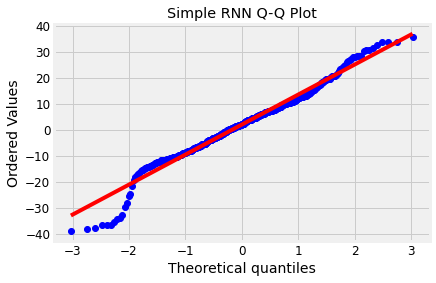

In [328]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(val_rnn_60_predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Simple RNN Q-Q Plot")

#### Validation

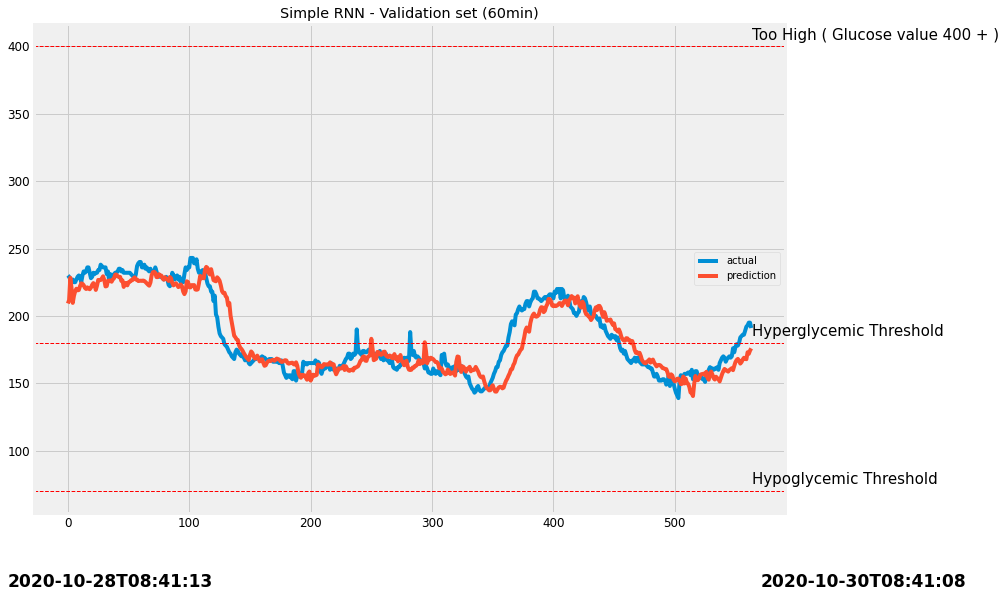

In [329]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Simple RNN - Validation set (60min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

Text(0.5, 1.0, 'Simple RNN 60min Normal Q-Q Plot')

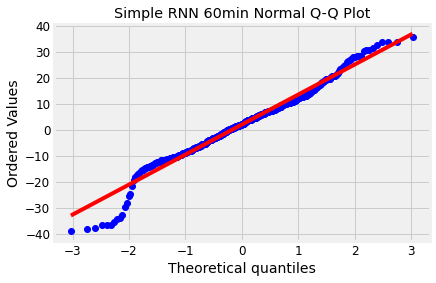

In [330]:
from pandas import DataFrame
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import probplot

#residuals=DataFrame(residuals)

residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)

#residuals

probplot(residuals,dist="norm",plot=plt)
plt.title("Simple RNN 60min Normal Q-Q Plot")

In [331]:
# 트레이닝셋 rmse 구하는 부분 
predict_result = model.predict(x_train_uni,verbose=0)
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400            
print(' Training set / Vanila RNN (Simple RNN) - RMSE (15min) : ',RMSE(y_train_uni_origin,predict_result))
train_rnn_60=RMSE(y_train_uni_origin,predict_result)

 Training set / Vanila RNN (Simple RNN) - RMSE (15min) :  23.03082927818023


In [332]:
y_train_uni_origin

array([232, 250, 243, ..., 223, 220, 225])

In [333]:
predict_result

array([[188.82974],
       [184.97594],
       [180.59056],
       ...,
       [208.70726],
       [209.89308],
       [207.36917]], dtype=float32)

#### Train

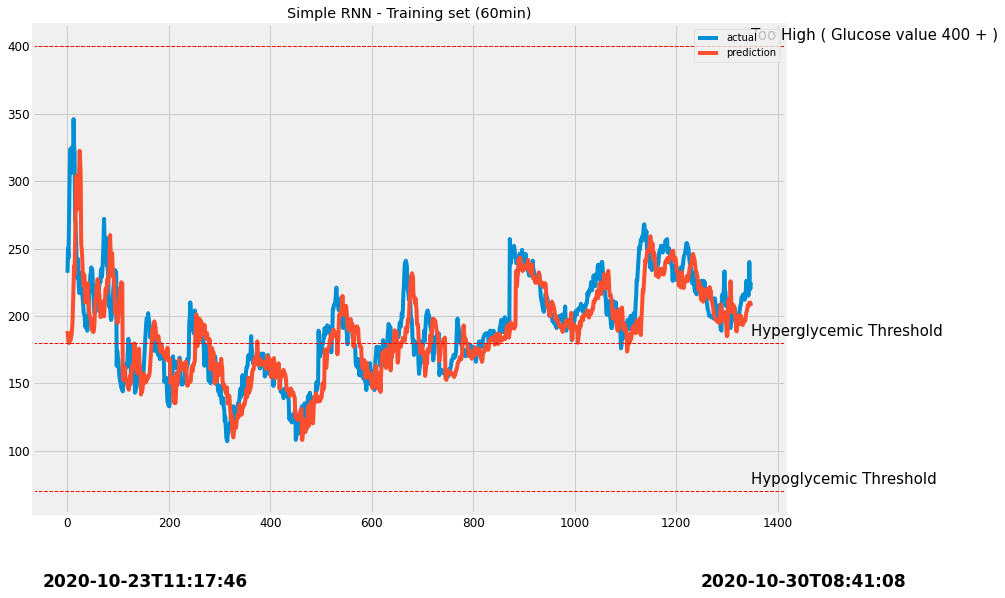

In [334]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Simple RNN - Training set (60min)',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### LSTM - 60분

In [335]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [336]:
model = Sequential()
model.add(LSTM(50,activation='relu',input_shape=x_train_uni.shape[-2:]))  #recurrent_dropout=0.2, unit_forget_bias=False
model.add(Dense(1))


model.compile(optimizer='adam',loss='mse')

model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)

K.clear_session()
val_lstm_60_predict_result = model.predict(x_val_uni,verbose=0)

In [337]:
predict_result = model.predict(x_val_uni,verbose=0)

# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

#predict_result

print(' LSTM - RMSE (60min) : ',RMSE(y_val_uni_origin,predict_result))
val_lstm_60=RMSE(y_val_uni_origin,predict_result)

 LSTM - RMSE (60min) :  11.867227397058866


In [338]:
predict_result

array([[212.0446 ],
       [211.29024],
       [227.72308],
       [216.2403 ],
       [215.10262],
       [219.8453 ],
       [220.4951 ],
       [215.27412],
       [218.328  ],
       [219.63007],
       [220.34853],
       [221.59052],
       [222.03165],
       [221.46062],
       [220.17482],
       [219.28795],
       [219.57947],
       [218.00871],
       [218.01811],
       [219.57936],
       [221.0161 ],
       [221.55284],
       [221.31474],
       [218.82387],
       [222.10841],
       [223.7542 ],
       [222.8539 ],
       [223.87332],
       [226.82626],
       [226.30606],
       [223.29512],
       [220.89624],
       [221.4243 ],
       [222.70087],
       [221.65253],
       [222.84865],
       [223.55312],
       [224.91718],
       [224.53986],
       [227.5356 ],
       [226.84044],
       [226.39474],
       [226.32181],
       [226.39651],
       [222.332  ],
       [223.78894],
       [218.93724],
       [222.14182],
       [220.40941],
       [220.25542],


#### 잔차

Text(0.5, 1.0, 'LSTM Q-Q Plot')

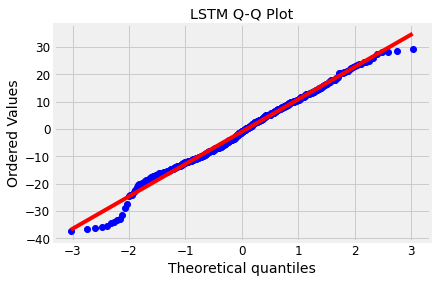

In [339]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("LSTM Q-Q Plot")

#### Validation

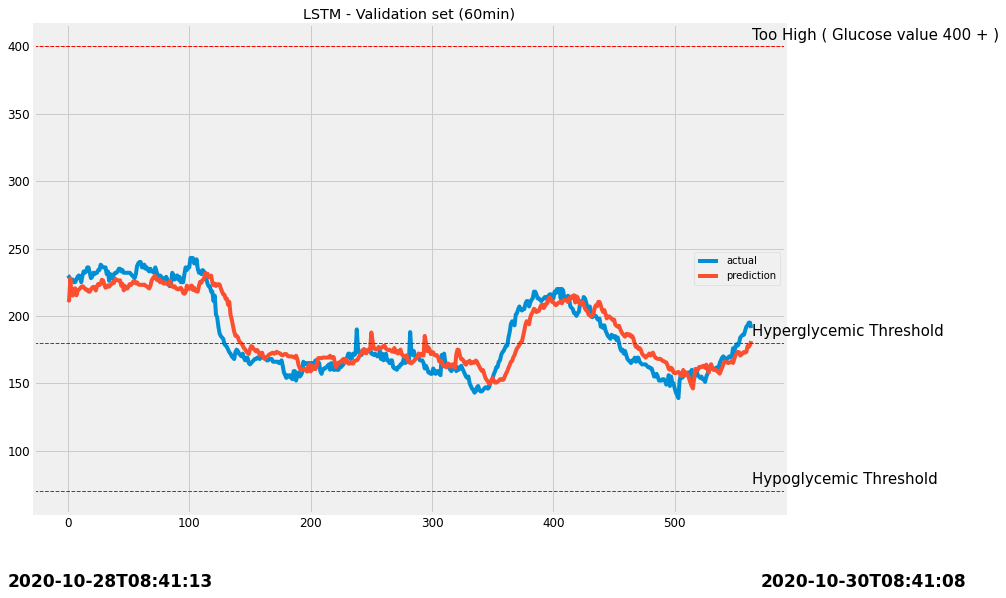

In [340]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('LSTM - Validation set (60min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [341]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' LSTM - RMSE (60min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_lstm_60 =RMSE(y_train_uni_origin,predict_result)

 LSTM - RMSE (60min) Training set :  21.945941728285128


#### Train

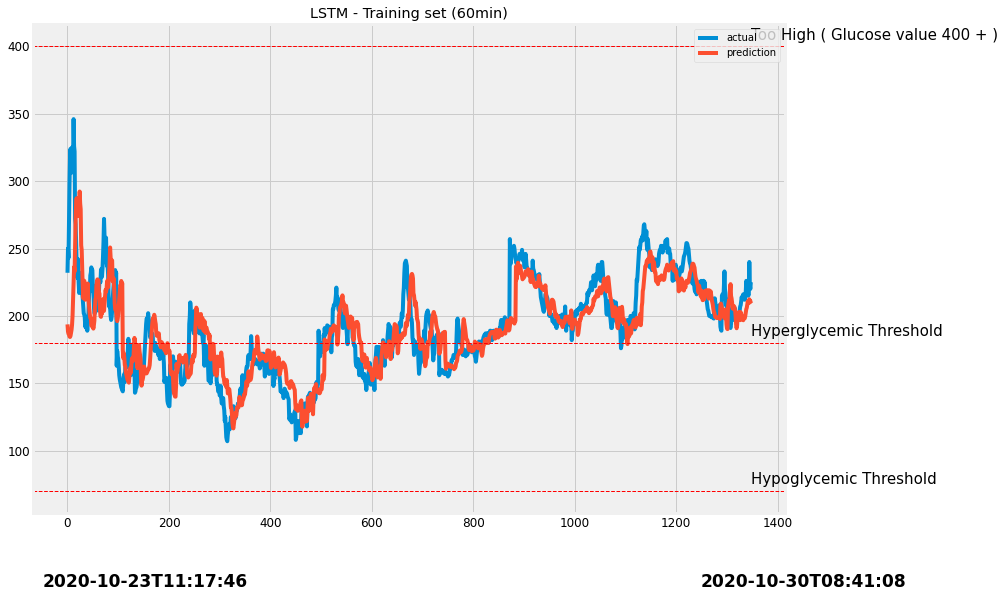

In [342]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('LSTM - Training set (60min)',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend()
plt.show()

### Stacked LSTM - 60분

In [343]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [344]:
model = Sequential()
model.add(LSTM(50,activation='relu',return_sequences=True,input_shape=x_train_uni.shape[-2:])) # recurrent_dropout=0.2
model.add(LSTM(50,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [345]:
model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)

K.clear_session()

In [346]:
val_slstm_60_predict_result = model.predict(x_val_uni,verbose=0)

In [347]:
predict_result = model.predict(x_val_uni,verbose=0)


for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

print(' Stacked LSTM - RMSE(15min) : ',RMSE(y_val_uni_origin,predict_result))
val_stacklstm_60 =RMSE(y_val_uni_origin,predict_result)

 Stacked LSTM - RMSE(15min) :  11.592656446604943


In [348]:
predict_result

array([[210.1585 ],
       [211.28223],
       [225.92815],
       [211.29404],
       [212.7722 ],
       [218.54857],
       [220.25745],
       [217.0728 ],
       [218.3142 ],
       [219.4062 ],
       [221.21707],
       [222.65013],
       [222.1861 ],
       [221.25546],
       [219.59744],
       [219.25594],
       [220.51991],
       [218.15346],
       [218.53682],
       [220.47942],
       [222.0766 ],
       [222.49286],
       [221.18344],
       [217.30501],
       [223.1219 ],
       [225.6094 ],
       [223.67487],
       [224.81895],
       [227.82   ],
       [227.32727],
       [222.97879],
       [220.06654],
       [222.32043],
       [225.19185],
       [223.2874 ],
       [224.28745],
       [224.09366],
       [226.2656 ],
       [225.77187],
       [229.68349],
       [227.72444],
       [227.15216],
       [227.58614],
       [227.8238 ],
       [222.24738],
       [225.66586],
       [217.50558],
       [223.8176 ],
       [221.46396],
       [220.94907],


#### 잔차

Text(0.5, 1.0, 'Stacked LSTM Q-Q Plot')

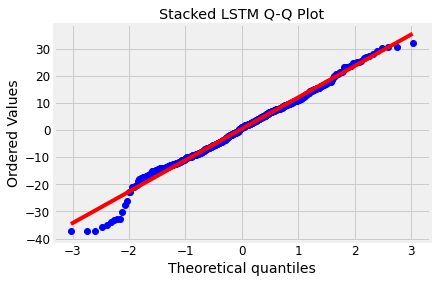

In [349]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Stacked LSTM Q-Q Plot")

#### Validation

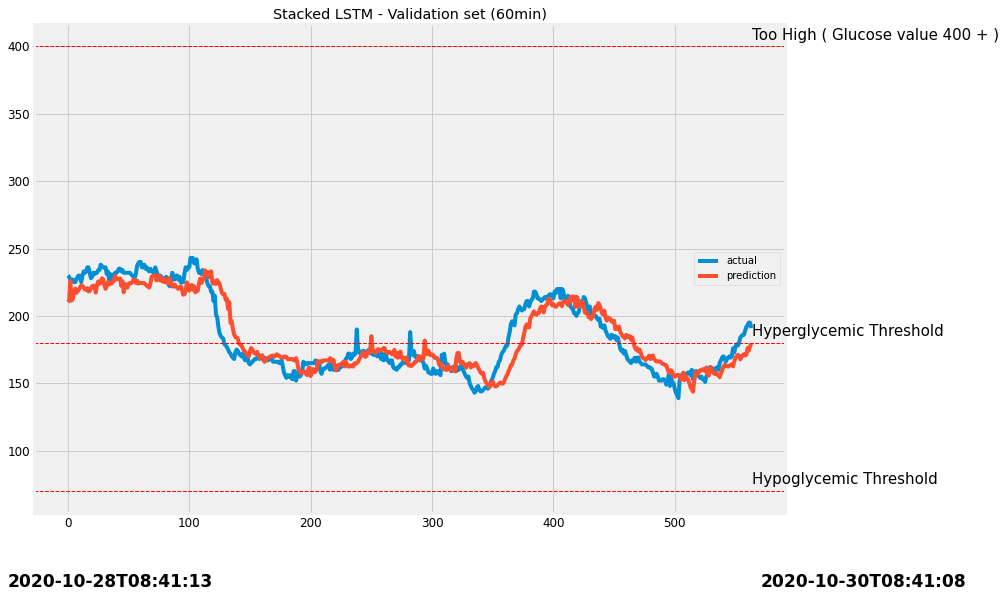

In [350]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Validation set (60min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [351]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / STACKED LSTM - RMSE (60min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_stacklstm_60 = RMSE(y_train_uni_origin,predict_result)

 Training set / STACKED LSTM - RMSE (60min) Training set :  21.849134512138633


#### Train

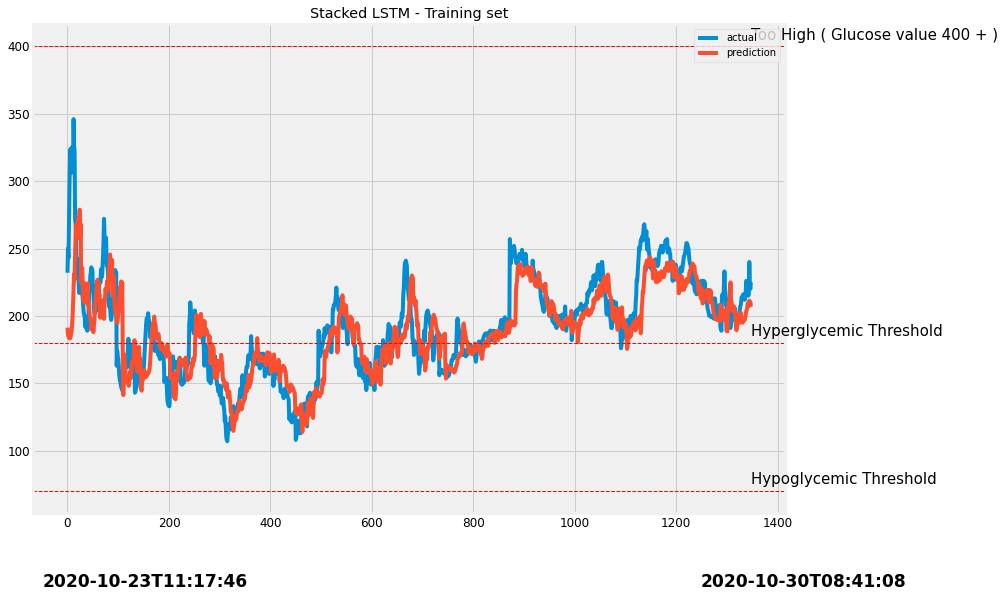

In [352]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### Bidirectional LSTM - 60분

In [353]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [354]:
from keras.layers import Bidirectional
from tensorflow.keras import layers
model = Sequential()

model.add(Bidirectional(LSTM(50,activation='relu',return_sequences=True),input_shape=x_train_uni.shape[-2:]))
model.add(Bidirectional(layers.LSTM(50,activation='relu')))
#model.add(Bidirectional(forward_layer,backward_layer=backward_layer,input_shape=x_train_uni.shape[-2:]))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [355]:
model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)

K.clear_session()
val_bilstm_60_predict_result = model.predict(x_val_uni,verbose=0)

In [356]:
predict_result.shape

(1348, 1)

In [357]:
predict_result = model.predict(x_val_uni,verbose=0)

for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

print('Bidirectional LSTM - RMSE : ',RMSE(y_val_uni_origin,predict_result))
val_bilstm_60 = RMSE(y_val_uni_origin,predict_result)

Bidirectional LSTM - RMSE :  12.079933002693567


In [358]:
predict_result

array([[208.2613 ],
       [208.09995],
       [224.32472],
       [215.77422],
       [215.04384],
       [216.13823],
       [215.92029],
       [214.51567],
       [216.07965],
       [216.5774 ],
       [217.74709],
       [219.36967],
       [219.80669],
       [219.16492],
       [217.5367 ],
       [216.39606],
       [216.71094],
       [215.46745],
       [215.51721],
       [216.80386],
       [218.38356],
       [219.4481 ],
       [219.14473],
       [216.33696],
       [218.96536],
       [220.96295],
       [221.09679],
       [222.02805],
       [223.98538],
       [223.98772],
       [221.42531],
       [218.31187],
       [218.15121],
       [219.9114 ],
       [219.80588],
       [220.9117 ],
       [221.02606],
       [222.30338],
       [222.3458 ],
       [225.19298],
       [224.8013 ],
       [224.30406],
       [223.91084],
       [223.76428],
       [220.32753],
       [221.24525],
       [216.42287],
       [219.3957 ],
       [218.02493],
       [217.9389 ],


#### Validation

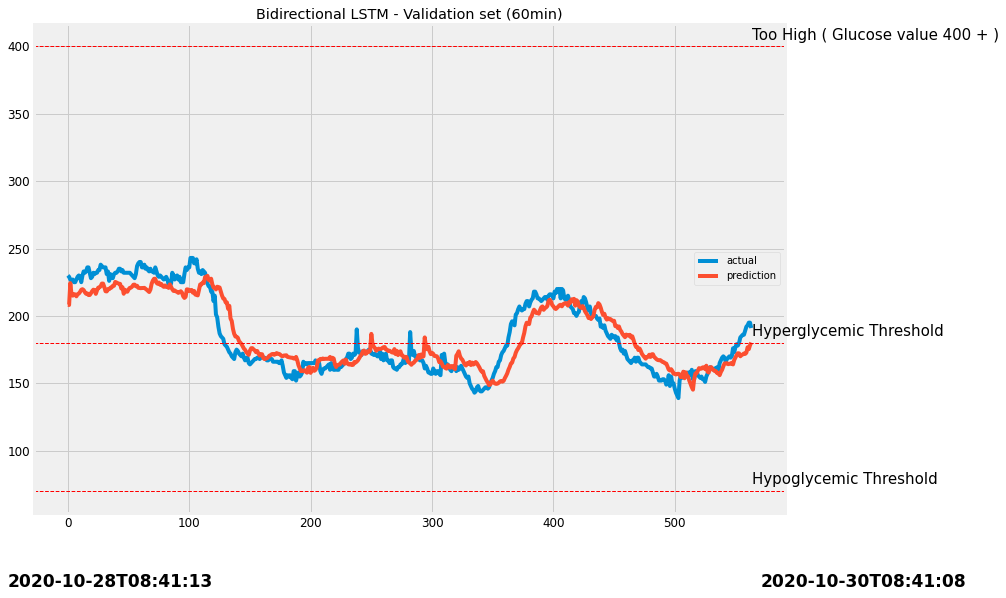

In [359]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Bidirectional LSTM - Validation set (60min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

#### 잔차

Text(0.5, 1.0, 'Bidirectional LSTM Q-Q Plot')

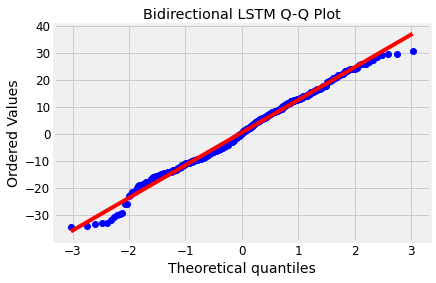

In [360]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Bidirectional LSTM Q-Q Plot")

In [361]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / Bidirectional LSTM - RMSE (60min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_bilstm_60 = RMSE(y_train_uni_origin,predict_result)

 Training set / Bidirectional LSTM - RMSE (60min) Training set :  21.68468128419748


#### Train

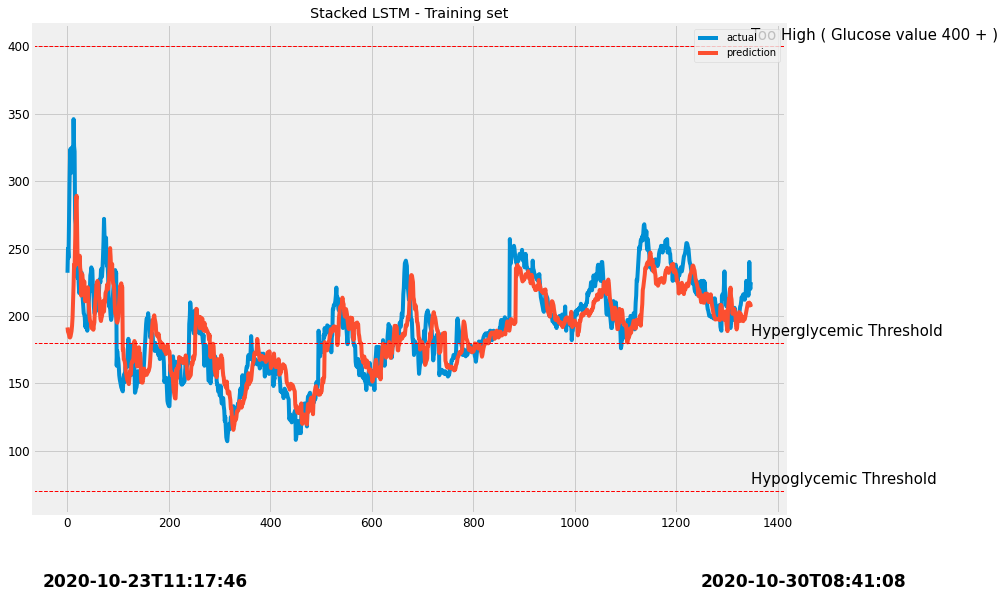

In [362]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### GRU - 60분

In [363]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [364]:
from keras.layers import GRU
model = Sequential()
model.add(GRU(50,activation='relu',input_shape=x_train_uni.shape[-2:]))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [365]:
model.summary()

model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)

K.clear_session()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 50)                7950      
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 8,001
Trainable params: 8,001
Non-trainable params: 0
_________________________________________________________________


In [366]:
val_gru_60_predict_result = model.predict(x_val_uni,verbose=0)
predict_result = model.predict(x_val_uni,verbose=0)

for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

#predict_result

#predict_result


print('GRU - RMSE 60min : ',RMSE(y_val_uni_origin,predict_result))
val_gru_60 = RMSE(y_val_uni_origin,predict_result)
# 상한선 400일 때 RMSE - 38.30 
# 상한선 400 X - 38.63

GRU - RMSE 60min :  12.103876684209725


In [367]:
predict_result

array([[209.35352],
       [208.93079],
       [227.26125],
       [216.04643],
       [212.59587],
       [216.923  ],
       [218.57715],
       [213.25645],
       [216.12135],
       [217.51859],
       [218.37755],
       [219.7413 ],
       [220.07697],
       [219.15854],
       [217.53448],
       [216.5032 ],
       [216.98729],
       [215.55057],
       [215.5077 ],
       [217.30544],
       [219.06027],
       [219.64941],
       [219.16292],
       [216.15471],
       [219.49808],
       [221.85135],
       [220.93907],
       [221.56548],
       [224.56291],
       [224.07462],
       [220.55954],
       [217.54552],
       [218.16422],
       [220.16284],
       [219.4277 ],
       [220.47319],
       [221.12575],
       [222.53261],
       [222.18707],
       [225.2731 ],
       [224.58017],
       [223.71996],
       [223.41707],
       [223.5626 ],
       [219.25925],
       [220.61836],
       [215.7869 ],
       [219.12177],
       [217.94518],
       [217.70383],


#### 잔차

Text(0.5, 1.0, 'GRU Q-Q Plot')

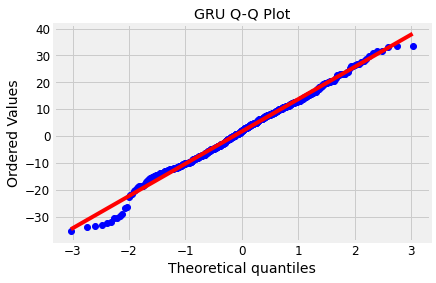

In [368]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("GRU Q-Q Plot")

#### Validation

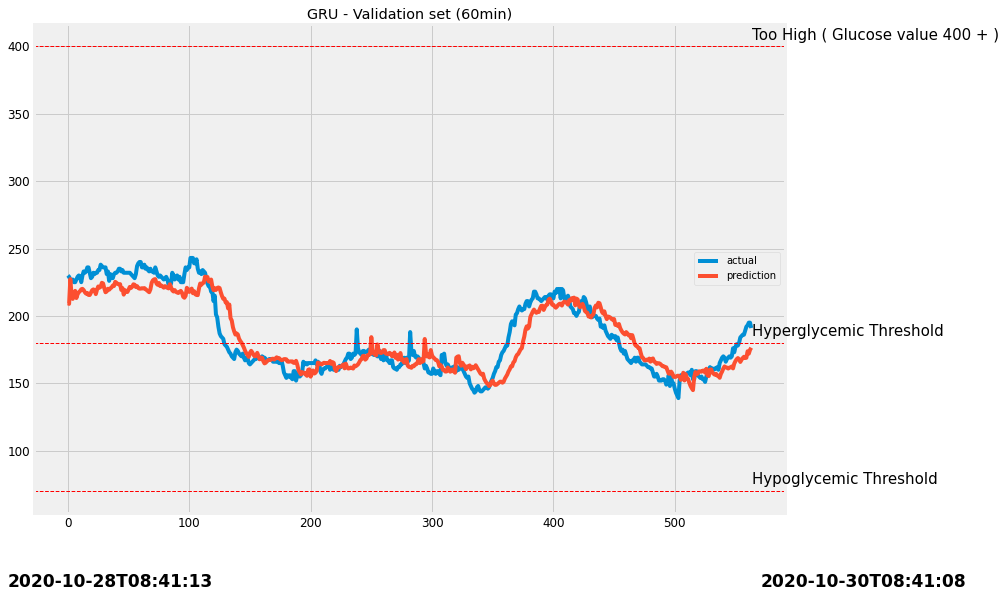

In [369]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('GRU - Validation set (60min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [370]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / GRU - RMSE (60min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_gru_60 =RMSE(y_train_uni_origin,predict_result)

 Training set / GRU - RMSE (60min) Training set :  22.020688234064128


#### Train

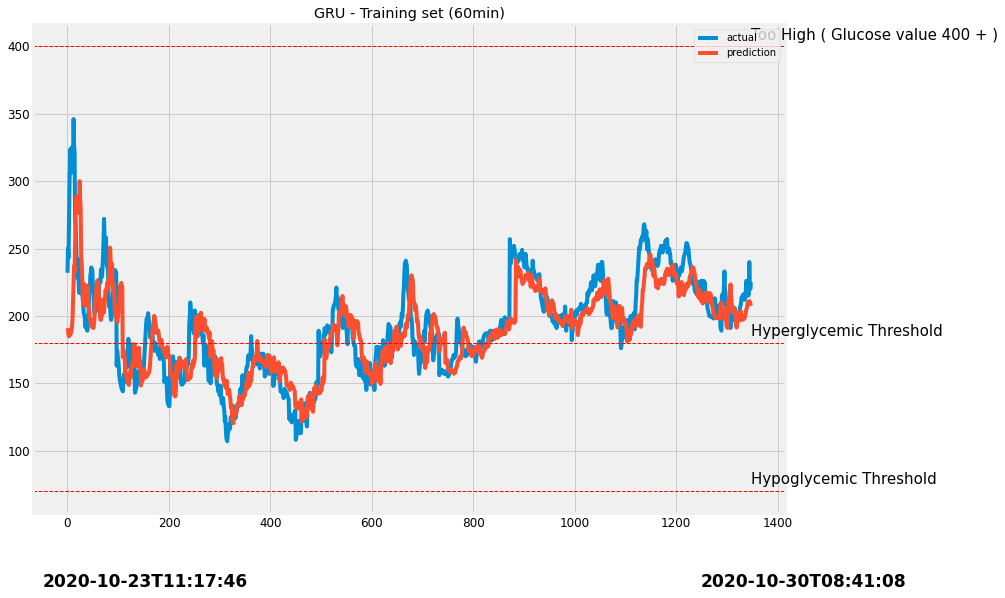

In [371]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('GRU - Training set (60min)',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### GA

In [372]:
val_rnn_60_predict_result = np.asarray(val_rnn_60_predict_result)
val_lstm_60_predict_result = np.asarray(val_lstm_60_predict_result)
val_slstm_60_predict_result = np.asarray(val_slstm_60_predict_result)
val_bilstm_60_predict_result = np.asarray(val_bilstm_60_predict_result)
val_gru_60_predict_result = np.asarray(val_gru_60_predict_result)

In [373]:
def evaluate2(X):
  pen = 0 
  #coef = [0,0,0,0,0]
  ab=0
  result =0
  #result2 = 0
  #print(X)
  if sum(X) > 0.99 and sum(X) < 1:
    #print("\n ** Count ** ")
    #print(count)
    #sum(coef)
    #pen = 2000 - sum(list1 * coef[0] + list2 * coef[1] + # 400 = 혈당측정기에서 수집한 EGV의 최댓값이 400
    #             list3 * coef[2] + list4 * coef[3] +
    #             list5 * coef[4])
    #RMSE(y_val_uni_origin,predict_result)
    #result = mean_squared_error((y_val_uni_origin,(val_rnn_30_predict_result * X[0] + val_lstm_30_predict_result * X[1] +
    #             val_slstm_30_predict_result * X[2] + val_bilstm_30_predict_result * X[3] +
    #             val_gru_30_predict_result * X[4]))**0.5)
   # ab = val_rnn_30_predict_result * X[0] + val_lstm_30_predict_result * X[1] +val_slstm_30_predict_result * X[2] + val_bilstm_30_predict_result * X[3] + val_gru_30_predict_result * X[4]
   # print("\n ** A ** \n")
   # print(ab.shape)
    result = 100 - np.sqrt(mean_squared_error(val_rnn_60_predict_result * X[0] + val_lstm_60_predict_result * X[1] +val_slstm_60_predict_result * X[2] + 
                                val_bilstm_60_predict_result * X[3] + val_gru_60_predict_result * X[4],y_val_uni_origin))
    
    #result = 10 - mean_squared_error(y_val_uni_origin,abc) / test_result 
    #result2=(test_result*5) - np.sqrt(result)
    #test_result =  mean_squared_error(y_val_uni_origin,ex)
    #test_result

    #pen = RMSE(y_val_uni_origin,result)
    #pen = 200 - np.sqrt(y_val_uni_origin,(val_rnn_15_predict_result * (X[0] / 10000) + val_lstm_15_predict_result * (X[1] / 10000) +
    #             val_slstm_15_predict_result * (X[2] / 10000) + val_bilstm_15_predict_result * (X[3] / 10000) +
    #             val_gru_15_predict_result * (X[4] / 10000)))
    # np.sqrt(mean_squared_error(y_test,y_predict))
    print("\n ** B ** \n")
    print(X)
    #print()
    print("\n ** C ** \n")
    print(result)
  #return np.sum(X) + pen
    #count += 1 
  return -result
    
    

In [374]:
varbound2 = np.array([[0.05, 0.5]]*5)

In [375]:
algorithm_param = {'max_num_iteration': 25000,
                   'population_size':100,
                   'mutation_probability':0.1,
                   'elit_ratio': 0.01,
                   'crossover_probability': 0.5,
                   'parents_portion': 0.3,
                   'crossover_type':'uniform',
                   'selection_type': 'roulette',
                   'max_iteration_without_improv':None}

In [376]:
model3 = ga(function = evaluate2, dimension = 5, variable_type='real',variable_boundaries=varbound2,algorithm_parameters = algorithm_param)

In [ ]:
model3.run()

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
88.20634229873312

 ** B ** 

[0.33171133 0.18058433 0.30928466 0.05338494 0.12503454]

 ** C ** 

88.35137535476724
||||||____________________________________________ 12.8% GA is running...3197 gen from 25000
 ** B ** 

[0.33171133 0.18058433 0.30335371 0.05338494 0.12503454]

 ** C ** 

88.20714387337065

 ** B ** 

[0.33171133 0.18058433 0.30928466 0.05338494 0.12503454]

 ** C ** 

88.35137535476724

 ** B ** 

[0.33171133 0.18058433 0.30335371 0.05338494 0.12503454]

 ** C ** 

88.20714387337065

 ** B ** 

[0.33171133 0.18058433 0.30928466 0.05338494 0.12503454]

 ** C ** 

88.35137535476724

 ** B ** 

[0.33171133 0.18058433 0.30335371 0.05338494 0.12503454]

 ** C ** 

88.20714387337065

 ** B ** 

[0.33171133 0.18058433 0.30928466 0.05338494 0.12503454]

 ** C ** 

88.35137535476724

 ** B ** 

[0.33171133 0.18058433 0.30332943 0.05338494 0.12503454]

 ** C ** 

88.20634229873312

 ** B ** 

[0.33171133 0.18058433 0.30335371 0.05338494 0.125

In [ ]:
# RMSE 
optimized = val_rnn_60_predict_result * model3.output_dict['variable'][0] + val_lstm_60_predict_result *model3.output_dict['variable'][1] + val_slstm_60_predict_result * model3.output_dict['variable'][2] + val_bilstm_60_predict_result * model3.output_dict['variable'][3] + val_gru_60_predict_result * model3.output_dict['variable'][4]
optimized_rmse_60 =  RMSE(y_val_uni_origin,optimized)
optimized_rmse_60

In [ ]:
optimized

In [ ]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(optimized,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(y_val_uni_origin),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(y_val_uni_origin),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(y_val_uni_origin),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Optimized',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(y_val_uni_origin)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

#### GA_Residual

In [ ]:
# Make a new dataframe of your prediction values
df_new = pd.DataFrame(df['Glucose'])
df_new.columns = ['rawseq']

# Retrieve index values
new_index = df_new['rawseq'].tail(len(optimized)).index

# Make a dataframe with your prediction values and your index
new_series = pd.DataFrame(index = new_index, data = optimized)

# Merge the dataframes
df_new = pd.merge(df_new, new_series, how = 'left', left_index=True, right_index=True)
df_new.columns = ['rawseq', 'optimized']

# And plot it
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))

plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)

plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(raw_seq),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(raw_seq),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(raw_seq),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Optimized - 60min',family='Times New Roman')
plt.plot(df_new['rawseq'],label='actual',linewidth=2)
plt.plot(df_new['optimized'], label='predicted',linewidth=2)
plt.legend(loc='best')
plt.show()

In [ ]:
residuals = [y_val_uni_origin[i]-optimized[i] for i in range(len(optimized))]
residuals = y_val_uni_origin - optimized.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("60Min GA Normal Q-Q Plot")

In [ ]:
probplot(residuals,dist="norm",plot=plt)
plt.title("60Min GA Normal Q-Q Plot")

In [ ]:
residuals=DataFrame(residuals)

In [ ]:
residuals.plot()

In [ ]:

residuals.hist()

In [ ]:
residuals.plot(kind='kde')

In [ ]:
from statsmodels.graphics.gofplots import qqplot
residuals=np.array(residuals)
qqplot(residuals)

## 결과

In [ ]:
train_15_result = [train_rnn_15,train_lstm_15,train_stacklstm_15,train_bilstm_15,train_gru_15]
val_15_result =[val_rnn_15,val_lstm_15,val_stacklstm_15,val_bilstm_15,val_gru_15,optimized_rmse_15]
train_30_result = [train_rnn_30,train_lstm_30,train_stacklstm_30,train_bilstm_30,train_gru_30]
val_30_result =[val_rnn_30,val_lstm_30,val_stacklstm_30,val_bilstm_30,val_gru_30,optimized_rmse_30]
train_60_result = [train_rnn_60,train_lstm_60,train_stacklstm_60,train_bilstm_60,train_gru_60]
val_60_result =[val_rnn_60,val_lstm_60,val_stacklstm_60,val_bilstm_60,val_gru_60,optimized_rmse_60]


In [ ]:
val_rnn_result = [val_rnn_15,val_rnn_30,val_rnn_60]
val_lstm_result = [val_lstm_15,val_lstm_30,val_lstm_60]
val_stacklstm_result = [val_stacklstm_15,val_stacklstm_30,val_stacklstm_60]
val_bilstm_result = [val_bilstm_15,val_bilstm_30,val_bilstm_60]
val_gru_result = [val_gru_15,val_gru_30,val_gru_60]
val_optimized_result = [optimized_rmse_15,optimized_rmse_30,optimized_rmse_60]

In [ ]:
train_rnn_result = [train_rnn_15,train_rnn_30,train_rnn_60]
train_lstm_result = [train_lstm_15,train_lstm_30,train_lstm_60]
train_stacklstm_result = [train_stacklstm_15,train_stacklstm_30,train_stacklstm_60]
train_bilstm_result = [train_bilstm_15,train_bilstm_30,train_bilstm_60]
train_gru_result = [train_gru_15,train_gru_30,train_gru_60]

In [ ]:
train_result_list =[train_rnn_result,train_lstm_result,train_stacklstm_result,train_bilstm_result,train_gru_result,]

In [ ]:
val_result_list =[val_rnn_result,val_lstm_result,val_stacklstm_result,val_bilstm_result,val_gru_result,val_optimized_result]

In [ ]:
val_result_list

In [ ]:
val_df = pd.DataFrame(index=['RNN','LSTM','Stacked LSTM','Bidirectional LSTM','GRU','Optimized'], 
                      columns =['15 MIN','30 MIN','60 MIN'],data=val_result_list)
val_df

In [ ]:
train_df = pd.DataFrame(index=['RNN','LSTM','Stacked LSTM','Bidirectional LSTM','GRU'], 
                      columns =['15 MIN','30 MIN','60 MIN'],data=train_result_list)
train_df

## CNN LSTM